# Contents
Hey, thanks for viewing my Kernel!

If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! :)

### [1. Introduction](#Introduction)

### [2. Exploratory Data Analysis](#Exploratory-Data-Analysis)

#### [2.1. Distributions](#Distributions)

#### [2.2. Exploration The Trees](#Exploration-The-Trees)

#### [2.3. F2 Metric Analysis](#F2-Metric-Analysis)

#### [2.4. Feature Engineering](#Feature-Engineering)

### [3. Validation](#Validation)

#### [3.1. Sklearn](#Sklearn)

#### [3.2. Transformers](#Transformers)

### [4. Modeling](#Modeling)

## 대회 요약
- kolibri studio 커리큘럼툴에서 데이터를 가져옴
    - 사용자들이 채널을 만들고
    - 토픽트리를 만들고 커리큘럼 분류, 계층적 구조 생성,
    - 토픽트리에 콘텐트 아이템을 넣음
    EX: econdary Education >> Ordinary Level >> Mathematics >> Further Learning >> Activities >> Trigonometry -> leaf topics  극좌표
- 목표 : 토픽트리를 통해 콘텐츠 아이템 예측
- 커리큘럼 전문가가 설정한 커리큘럼과 비교 + 다른 사용자의 결과와 비교


## 데이터셋
- topic csv
    - channels로 구성되어 있음.(하나의 토픽트리로 구성)
    - id : 토픽 id
    - title : 토픽 타이틀
    - decription : 텍스트 요약(결측값 존재)
    - channel : 토픽트리
    - category : 토픽 category 요약
        - source : 원래 콘텐츠 생성자로부터 주어진 category
        - aligned : 국가 커리큘럼 또는 다른 분류 체계
        - supplemental : 어느정도 정렬됨, 정렬된 채널과 같은 수준의 세분성이나 충실도 없음
    - language : 타이틀과 설명의 언어와 항상 같은 것은 아님, 관련된 content의 언어와 항상 일치
    - parent : 이 토픽을 포함하고 있는 토픽 아이디. 만약 이 데이터가 비어있다면 주제가 해당 채널의 root node일 경우
    - level : 그 토픽트리가 있는 토픽의 깊이. level 0 이 루느 노드임, 그리고 이 타이틀은 채널의 타이틀이다.
    - has_content : 이 토픽과 연관된 content 아이템이 있는지 여부. 대부분의 content는 leaf topics와 관련있지만, non-leaf topics 또한 상관관계가 있을 수 있다.
    

- content.csv : 데이터셋의 각각 content 아이템의 행을 포함함, 몇몇 content는 어떤 topic과도 연관 없을 수 있음
    - id : content 아이템의 id
    - title : 이 content 아이템에 대한 title text
    - description : 설명
    - language : 콘텐츠 아이템의 언어
    - kind : 이 아이템 태표 콘텐츠가 무엇인지 알려줌
        - document : 텍스트가 pdf, Epub으로 추출되었는지
        - video : 텍스트의 부제목
        - exercise : QA에서 가져왔는지
        - audio : 텍스트가 없음
        - html5 : HTML에서 가져왔는지
    - text : 텍스트 콘텐츠 추출, 추출이 가능하고, 라이센스가 허용되어 있다면. 50% 존재
    - copyright_holder : 텍스트가 content에서 가져왔을때 저작권자
    - license : content에서 텍스트를 추출했을때, content가 만들어지는 라이센스

- correlations.csv : 학습 셋에서 토픽과 연관된 content아이템. 하나의 content는 하나의 topic과 연관됨.

# Introduction 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
import datetime as dt
import math

np.random.seed(0)
warnings.simplefilter("ignore")

In [2]:
from IPython.core.display import HTML
def nan_counts_all(df_dict):
    pd.set_option('display.max_rows', 50)
    table_list = []
    for key in df_dict:
        table_list.append(pd.DataFrame(df_dict[key].isna().sum(), columns=[key]))
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

def nunqiue_all(df_dict):
    pd.set_option('display.max_rows', 50)
    table_list = []
    for key in df_dict:
        table_list.append(pd.DataFrame(df_dict[key].nunique(), columns=[key]))
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

def value_counts_all(df, columns):
    pd.set_option('display.max_rows', 50)
    table_list = []
    for col in columns:
        table_list.append(pd.DataFrame(df[col].value_counts()))
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [3]:
BASE_DIR = "/kaggle/input/learning-equality-curriculum-recommendations/"
content = pd.read_csv(BASE_DIR+"content.csv")
correlations = pd.read_csv(BASE_DIR+"correlations.csv")
topic = pd.read_csv(BASE_DIR+"topics.csv")
sub = pd.read_csv(BASE_DIR+"sample_submission.csv")

display(content.head())
display(topic.head())
display(correlations.head())
display(sub.head())

,id,title,description,kind,text,language,copyright_holder,license
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA


,id,title,description,channel,category,level,language,parent,has_content
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True


,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_0008768bdee6,c_34e1424229b4 c_7d1a964d66d5 c_aab93ee667f4


,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_4054df11a74e,c_3695c5dc1df6 c_f2d184a98231


In [4]:
print("content shape:", content.shape)
print("topic shape:", topic.shape)
print("correlations shape:", correlations.shape)
print("sub shape:", sub.shape)

content shape: (154047, 8)
topic shape: (76972, 9)
correlations shape: (61517, 2)
sub shape: (5, 2)


In [5]:
print("content nan value sum:", content.isna().sum().sum())
print("topic nan value sum:", topic.isna().sum().sum())
print("correlations nan value sum:", correlations.isna().sum().sum())
print("sub nan value sum:", sub.isna().sum().sum())

content nan value sum: 306850
topic nan value sum: 42192
correlations nan value sum: 0
sub nan value sum: 0


In [6]:
df_dict = {
    'Content':content,
    'Topic':topic
}
nan_counts_all(df_dict)

,Content
id,0
title,9
description,64591
kind,0
text,80012
language,0
copyright_holder,82226
license,80012
,Topic
id,0


In [7]:
# 라이센스 결측치 처리
content["license"] = content["license"].fillna("None")

In [8]:
# 중복값 확인
print("content dublicated value sum:", content.duplicated().sum().sum())
print("topic dublicated value sum:", topic.duplicated().sum().sum())
print("correlations dublicated value sum:", correlations.duplicated().sum().sum())
print("sub dublicated value sum:", sub.duplicated().sum().sum())

content dublicated value sum: 0
topic dublicated value sum: 0
correlations dublicated value sum: 0
sub dublicated value sum: 0


In [9]:
# 유니크한것들의 갯수
nunqiue_all(df_dict)

,Content
id,154047
title,130937
description,76305
kind,5
text,70687
language,27
copyright_holder,148
license,8
,Topic
id,76972


In [10]:
# 값 갯수 확인
value_counts_all(content, ["kind", "language", "license"])

,kind
video,61487
document,33873
html5,32563
exercise,25925
audio,199
,language
en,65939
es,30844
fr,10682
pt,10435


## 콘텐츠 데이터에서
- 비디오 데이터가 가장 많음
- en 데이터가 가장 많음

In [11]:
value_counts_all(topic, ["category", "level", "language", "has_content"])

# 카테고리에선 소스데이터가 가장 많음
# 깊이는 4,3이 가장 많음

,category
source,43487
supplemental,19368
aligned,14117
,level
4,38810
3,14898
5,9744
6,6210
2,4874
1,1104


# Exploratory Data Analysis

In [12]:
def cat_cat_dist(data=None, feat1="", feat2="", feat1_lim="all", h=True, figsize=(16, 4), title="", title_fontsize=20, rotate=False, cut_xlabel=False):
    # 데이터 복사
    data_copy = data.copy()
    # 카운트가 1인것들 가져옴
    data_copy.loc[:, "count"] = 1
    
    if feat1_lim != "all":
        feat1_lim_value = data_copy[feat1].value_counts().index[:feat1_lim]
        data_copy = data_copy.loc[data_copy[feat1].isin(feat1_lim_value), :]
        if cut_xlabel:
            data_copy[feat1] = data_copy[feat1].str[:int((1/feat1_lim)*400)]
    # 기초 통계량
    data_copy = data_copy.groupby([feat1, feat2], as_index=False).agg({"count":"sum"})
    data_copy_div = data_copy.groupby([feat1], as_index=False).agg({"count":"sum"})
    data_copy_div.columns = [feat1, "div"]
    data_copy = data_copy.merge(data_copy_div, on=feat1)
    data_copy["normalized_count"] = data_copy["count"] / data_copy["div"] 
    data_copy.sort_values("count", inplace=True, ascending=False)
    if h:
        fig, axes = plt.subplots(2, figsize=figsize)
        fig.suptitle(title, fontsize=title_fontsize)
        sns.barplot(data=data_copy, x=feat1, y="count", hue=feat2, ax=axes[0])
        sns.barplot(data=data_copy, x=feat1, y="normalized_count", hue=feat2, ax=axes[1])
        if rotate:
            x_labels = data_copy[feat1].unique()
            axes[0].set_xticklabels(x_labels, rotation = 45)
            axes[1].set_xticklabels(x_labels, rotation = 45)
            fig.tight_layout()
    else:
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        fig.suptitle(title, fontsize=title_fontsize)
        sns.barplot(data=data_copy, x=feat1, y="count", hue=feat2, ax=axes[0])
        sns.barplot(data=data_copy, x=feat1, y="normalized_count", hue=feat2, ax=axes[1])
        if rotate:
            x_labels = data_copy[feat1].unique()
            axes[0].set_xticklabels(x_labels, rotation = 45)
            axes[1].set_xticklabels(x_labels, rotation = 45)
            fig.tight_layout()

## Distributions

## Correlations

In [13]:
# correlations의 길이 + 토픽데이터의 id, has_content 매핑
content_ids_df = pd.DataFrame()
content_ids = correlations["content_ids"].str.split(" ")
content_ids_df["topic_id"] = correlations["topic_id"].values
content_ids_df["content_ids"] = content_ids
content_ids_df["content_ids_len"] = content_ids.str.len()
content_ids_df = content_ids_df.merge(topic[["id", "has_content"]], left_on="topic_id", right_on="id")

content_ids_df.head()

,topic_id,content_ids,content_ids_len,id,has_content
0,t_00004da3a1b2,"[c_1108dd0c7a5d, c_376c5a8eb028, c_5bc0e1e2cba...",4,t_00004da3a1b2,True
1,t_00068291e9a4,"[c_639ea2ef9c95, c_89ce9367be10, c_ac1672cdcd2...",4,t_00068291e9a4,True
2,t_00069b63a70a,[c_11a1dc0bfb99],1,t_00069b63a70a,True
3,t_0006d41a73a8,"[c_0c6473c3480d, c_1c57a1316568, c_5e375cf14c4...",5,t_0006d41a73a8,True
4,t_0008768bdee6,"[c_34e1424229b4, c_7d1a964d66d5, c_aab93ee667f4]",3,t_0008768bdee6,True


In [14]:
content_ids_df.groupby("has_content").agg({"content_ids_len":["mean", "median"]})

content_ids_len       
                       mean median
has_content                       
True               4.550271    3.0

In [15]:
correlations

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_0008768bdee6,c_34e1424229b4 c_7d1a964d66d5 c_aab93ee667f4
...,...,...
61512,t_fff830472691,c_61fb63326e5d c_8f224e321c87
61513,t_fff9e5407d13,c_026db653a269 c_0fb048a6412c c_20de77522603 c...
61514,t_fffbe1d5d43c,c_46f852a49c08 c_6659207b25d5
61515,t_fffe14f1be1e,c_cece166bad6a


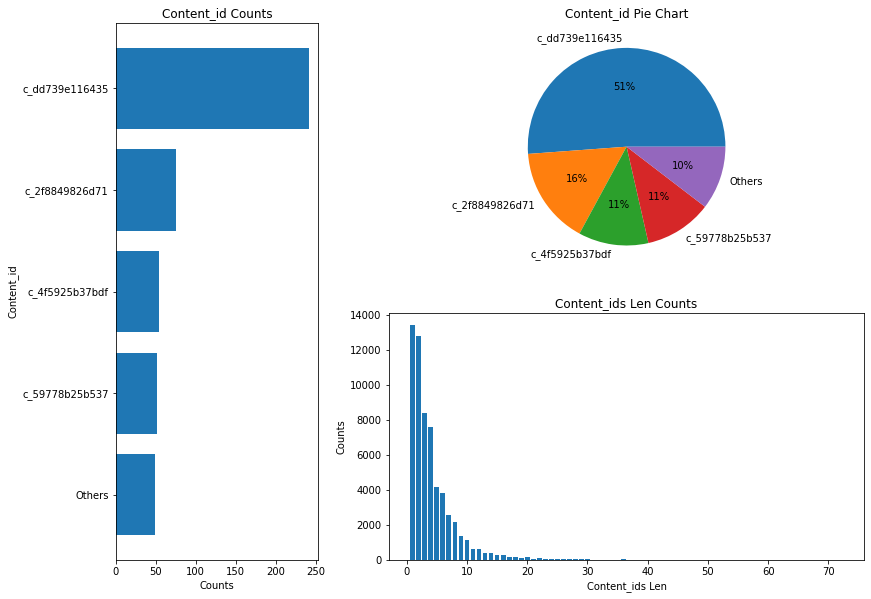

In [16]:
fig = plt.figure(figsize=(16, 12)) # initialize figure
axes = [None for _ in range(3)] # list to save many ax for setting parameter in each
axes[0] = plt.subplot2grid((3,4), (0,0), colspan=1, rowspan=2)
axes[1] = plt.subplot2grid((3,4), (0,1), colspan=2)
axes[2] = plt.subplot2grid((3,4), (1,1), colspan=2)

# Chart 0
content_dict = {content_id: 0 for content_id in content["id"]}
for index, row in content_ids_df.iterrows():
    for content_id in row["content_ids"]:
        content_dict[content_id]+=1

content_ids_count_series = pd.Series(content_dict)
content_ids_count_series.sort_values(inplace=True, ascending=False)

content_ids_count_df = content_ids_count_series.to_frame()
content_ids_count_df.reset_index(inplace=True)
content_ids_count_df.columns = ["content_id", "count"]

content_ids_count_df.loc[content_ids_count_df["count"]<=49, ["content_id", "count"]] = ["Others", 49]
content_ids_count_df.drop_duplicates(inplace=True)

axes[0].barh(content_ids_count_df["content_id"][::-1], content_ids_count_df["count"][::-1]);
axes[0].set_title("Content_id Counts")
axes[0].set_xlabel("Counts")
axes[0].set_ylabel("Content_id")

# Chart 1
axes[1].pie(content_ids_count_df["count"], labels = content_ids_count_df["content_id"],  autopct='%.0f%%');
axes[1].set_title("Content_id Pie Chart")

# Chart 2
content_ids_len_counts = content_ids_df["content_ids_len"].value_counts()[:50]
axes[2].bar(content_ids_len_counts.index, content_ids_len_counts.values)
axes[2].set_title("Content_ids Len Counts")
axes[2].set_xlabel("Content_ids Len")
axes[2].set_ylabel("Counts");

fig.tight_layout()

In [17]:
# id와 count를 붙임
content.merge(content_ids_count_df, left_on="id", right_on="content_id")

,id,title,description,kind,text,language,copyright_holder,license,content_id,count
0,c_2f8849826d71,InfoPage,NaN,html5,This open text is disseminated via the Open Ed...,en,CSU and Merlot,CC BY-NC-SA,c_2f8849826d71,75
1,c_4f5925b37bdf,Index,NaN,html5,NaN,en,NaN,None,c_4f5925b37bdf,54
2,c_59778b25b537,Pasos siguientes,Descubra los pasos siguientes y recursos adici...,html5,Para recibir el certificado que necesita para ...,es,HP LIFE,CC BY,c_59778b25b537,52
3,c_dd739e116435,বই,NaN,document,NaN,bn,NaN,None,c_dd739e116435,241


In [18]:
# 타겟 콘텐츠의 히스토 보기
def target_content_dist(feature="kind", ncols=3, h=False, figsize=(16,8)):
    feature_unique = content[feature].unique()
    feat_dict = {v: {v_inner:0 for v_inner in feature_unique} for v in feature_unique}
    
    content_id_map = content.set_index("id").to_dict()[feature]
    for index, row in content_ids_df.iterrows():
        row_values = []
        for content_id in row["content_ids"]:
            row_values.append(content_id_map[content_id])
        for v_uniq in set(row_values):
            for f_uniq in feature_unique:
                feat_dict[v_uniq][f_uniq] += row_values.count(f_uniq)
            feat_dict[v_uniq][v_uniq] -= 1
    
    nrows = int((len(feature_unique)+1) / ncols)
    if (len(feature_unique)+1) % ncols != 0:
        nrows += 1
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for index, ax in enumerate(axes.ravel()[:len(feature_unique)+1]):
        if h:
            if index==0:
                feature_count = content[feature].value_counts()
                ax.barh(feature_count.index, feature_count.values)
                ax.set_title(f"{feature} counts")
                ax.set_ylabel("count")
                ax.set_xlabel(feature)
            else:
                feat_name = feature_unique[index-1]
                ax.barh(list(feat_dict[feat_name].keys()), list(feat_dict[feat_name].values()))
                ax.set_title(feat_name)
                ax.set_ylabel("count")
                ax.set_xlabel(feature)
        else:
            if index==0:
                feature_count = content[feature].value_counts()
                ax.bar(feature_count.index, feature_count.values)
                ax.set_title(f"{feature} counts")
                ax.set_ylabel("count")
                ax.set_xlabel(feature)
            else:
                feat_name = feature_unique[index-1]
                ax.bar(feat_dict[feat_name].keys(), feat_dict[feat_name].values())
                ax.set_title(feat_name)
                ax.set_ylabel("count")
                ax.set_xlabel(feature)
    for ax in axes.ravel()[len(feature_unique)+1:]:
        ax.set_visible(False)
    fig.tight_layout()

In [19]:
# 콘텐츠 id 길이 분석
def content_ids_len_analysis(feature_name="kind", ncols=3, figsize=(16,8)):
    from matplotlib.offsetbox import AnchoredText
    
    feature_unique = content[feature_name].unique()
    df_content_ids_analysis = pd.DataFrame()
    for index, row in content_ids_df.iterrows():
        feature_dict = {feature_id: 0 for feature_id in feature_unique}
        content_part = content.loc[content["id"].isin(row["content_ids"]), :]
        value_counts = content_part[feature_name].value_counts()
        for v in feature_unique:
            try:
                feature_dict[v] = value_counts[v]
            except:
                feature_dict[v] = 0
        df_content_ids_analysis = df_content_ids_analysis.append(feature_dict, ignore_index=True)
    df_content_ids_analysis["content_ids_len"] = content_ids_df["content_ids_len"].values
    
    nrows = int((len(feature_unique)+1) / ncols)
    if (len(feature_unique)+1) % ncols != 0:
        nrows += 1
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for index, (ax, feature) in enumerate(zip(axes.ravel()[:len(feature_unique)], feature_unique)):
        corr = df_content_ids_analysis[feature].corr(df_content_ids_analysis["content_ids_len"])
        scatter_kws = dict(
            alpha=0.75,
            s=3,
        )
        line_kws = dict(color='C3', )
        ax = sns.regplot(x=df_content_ids_analysis[feature],
                         y=df_content_ids_analysis["content_ids_len"],
                         scatter_kws=scatter_kws,
                         line_kws=line_kws,
                         lowess=True,
                         ax=ax)
        at = AnchoredText(
            f"{corr:.2f}",
            prop=dict(size="large"),
            frameon=True,
            loc="upper left",
        )
        at.patch.set_boxstyle("square, pad=0.0")
        ax.add_artist(at)
        
        ax.set_title(f"{feature} - content_ids_len scatter plot")
        ax.set_ylabel("content_ids_len")
        ax.set_xlabel(feature)
    for ax in axes.ravel()[len(feature_unique):]:
        ax.set_visible(False)
    fig.tight_layout()

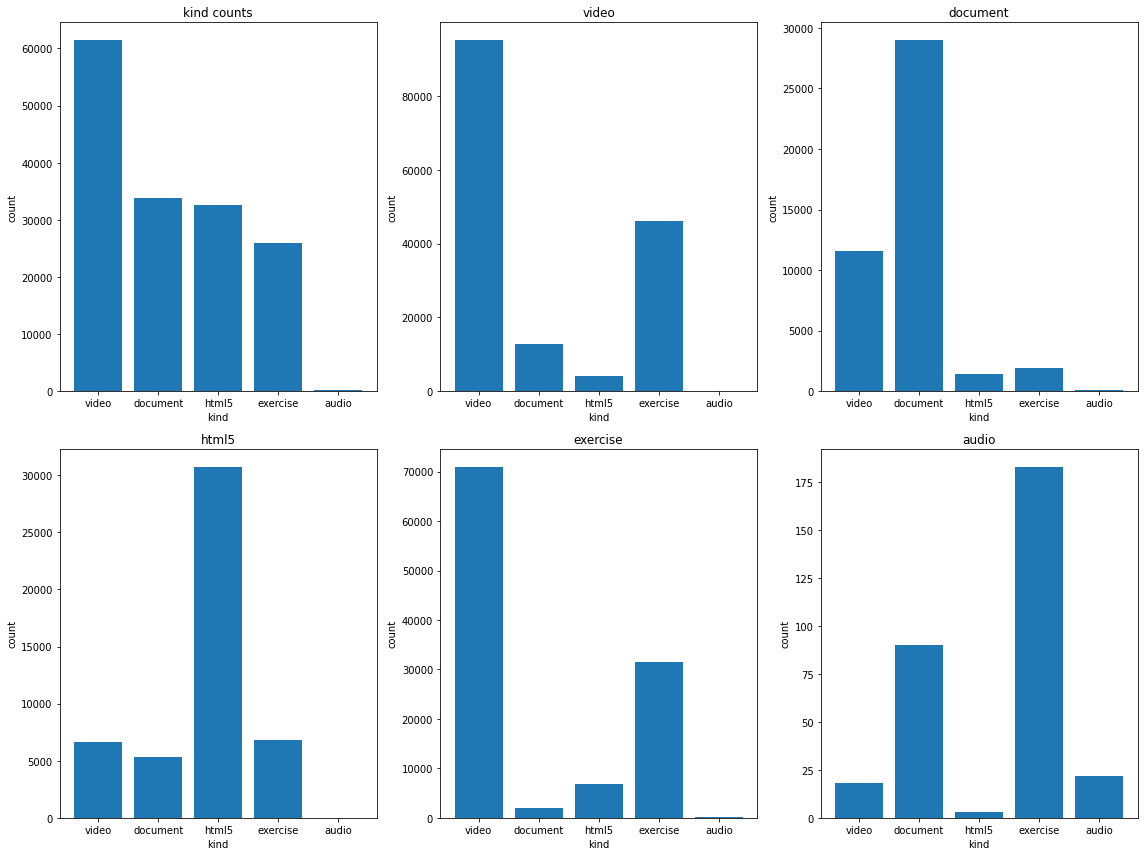

In [20]:
target_content_dist(feature="kind", ncols=3, figsize=(16,12))

In [21]:
# content_ids_len_analysis(feature_name="kind", ncols=5, figsize=(16,6));

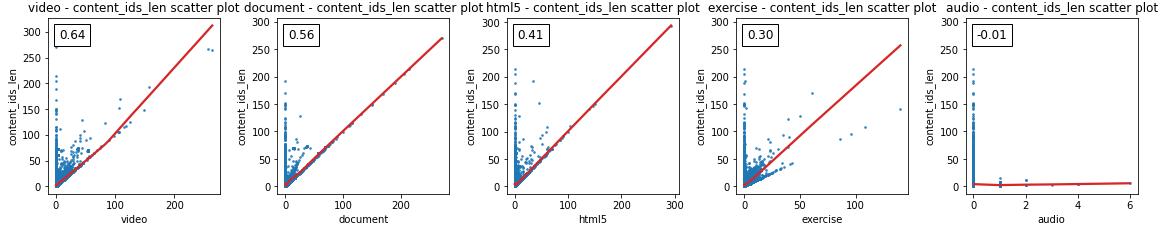

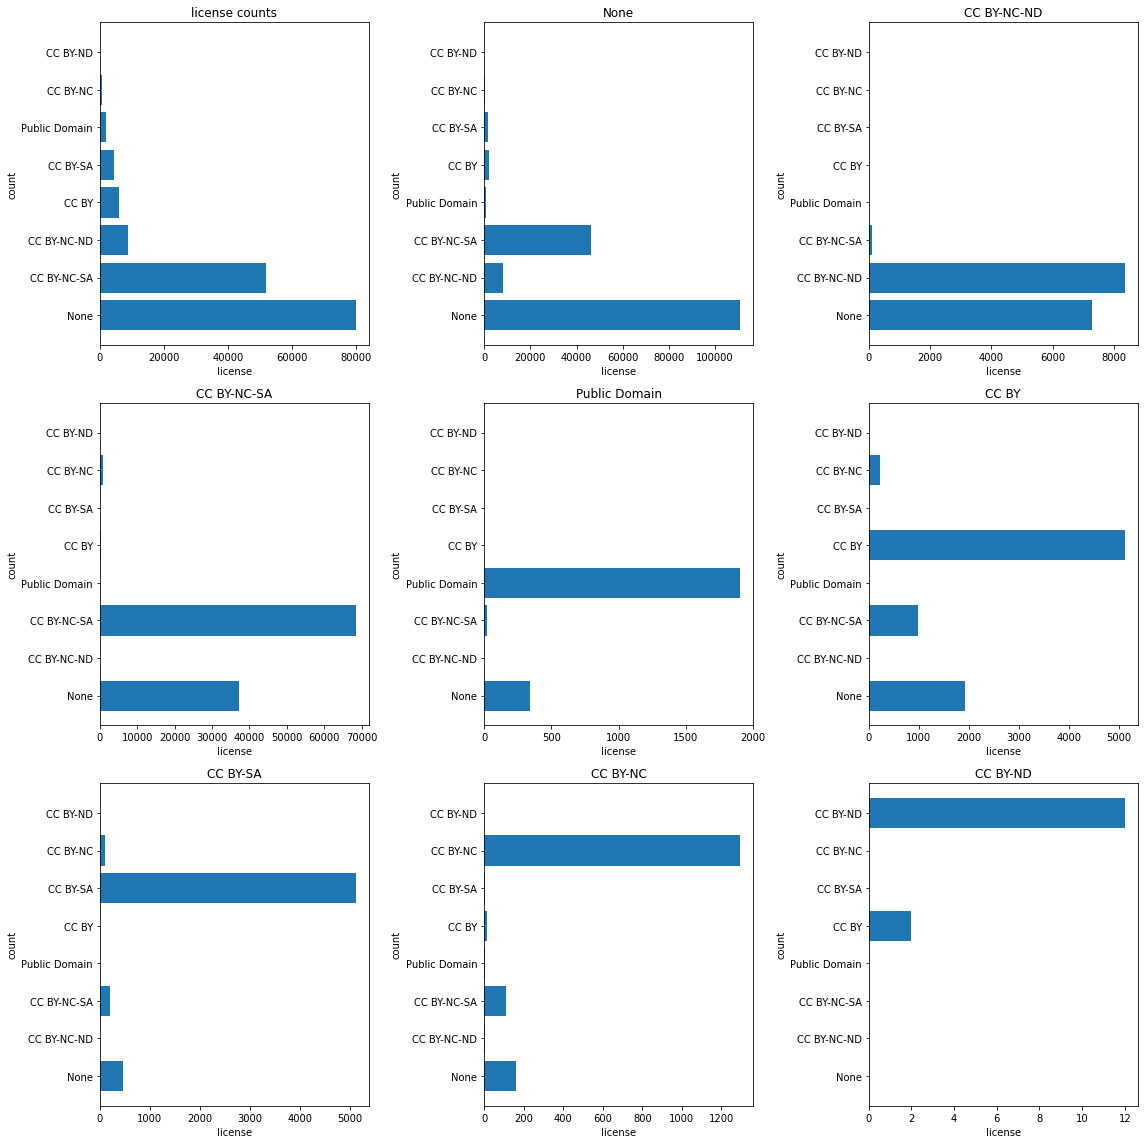

In [22]:
# 라이센스별 dist
target_content_dist(feature="license", ncols=3, figsize=(16,16), h=True)

In [23]:
#content_ids_len_analysis(feature_name="license", ncols=4, figsize=(16,12));

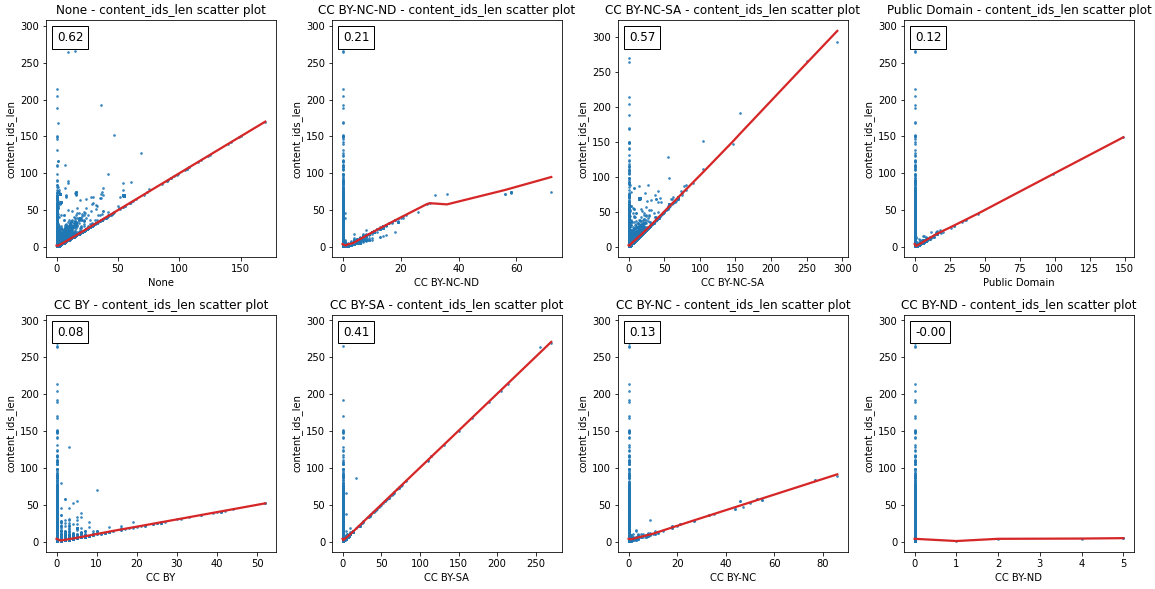

### Content

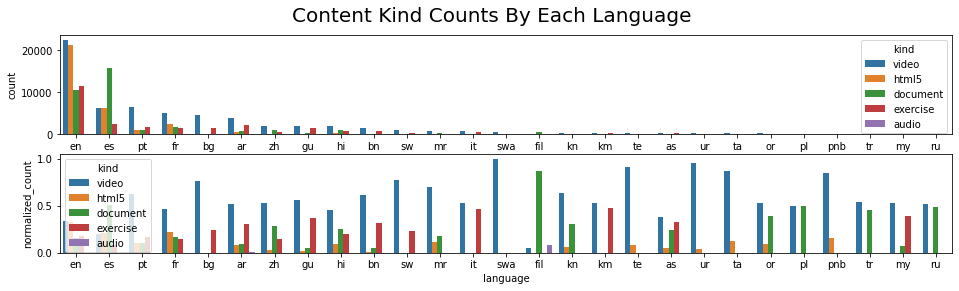

In [24]:
# 언어별 콘텐츠 카운트
cat_cat_dist(data=content, feat1="language", feat2="kind", title="Content Kind Counts By Each Language")

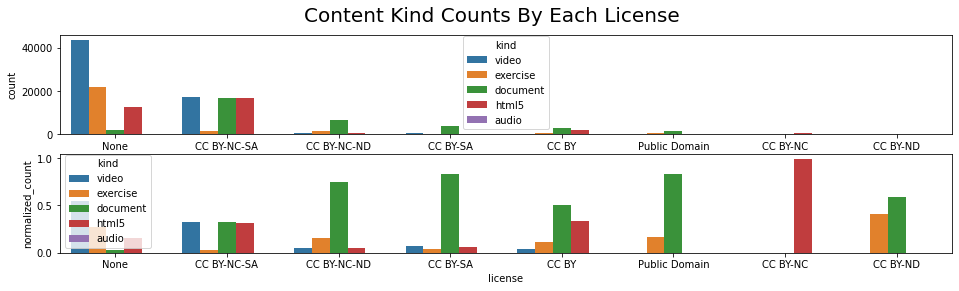

In [25]:
# 라이센스별 콘텐츠 카운트
cat_cat_dist(data=content, feat1="license", feat2="kind", title="Content Kind Counts By Each License")

### licenses
* **CC BY-NC-SA:** This license lets others remix, tweak, and build upon your work non-commercially, as long as they credit you and license their new creations under the identical terms.
* **CC BY-NC-ND:** This license is the most restrictive license offered by Creative Commons. With this license, the user (while attributing the original creator) can only share the work but not change it in any way or ever use it commercially.
* **CC BY-SA:** This license allows reusers to distribute, remix, adapt, and build upon the material in any medium or format, so long as attribution is given to the creator. 
* **CC BY:** This license allows reusers to distribute, remix, adapt, and build upon the material in any medium or format, so long as attribution is given to the creator. The license allows for commercial use.
* **Public Domain:** Public-domain-equivalent license are licenses that grant public-domain-like rights and/or act as waivers. They are used to make copyrighted works usable by anyone without conditions, while avoiding the complexities of attribution or license compatibility that occur with other licenses. 
* **CC BY-NC:** This license allows reusers to distribute, remix, adapt, and build upon the material in any medium or format for noncommercial purposes only, and only so long as attribution is given to the creator.
* **CC BY-ND:** This license allows reusers to copy and distribute the material in any medium or format in unadapted form only, and only so long as attribution is given to the creator. The license allows for commercial use. 

**Sources:**
<br> [1]: https://guides.lib.umich.edu/creativecommons/licenses </br>
<br> [2]: https://libguides.hartford.edu/ </br>
<br> [3]: https://creativecommons.org/about/cclicenses/ </br>
<br> [4]: https://en.wikipedia.org/wiki/Public-domain-equivalent_license </br>

### licenses
* **CC BY-NC-SA:** 이 자격증은 다른 사람들이 당신에게 credit을 주고 동일한 조건으로 새로운 창작물에 라이센스를 부여하는 비상업적으로 작품을 리믹스하고 수정하고 구축할 수 있게 해준다.
* **CC BY-NC-ND:** 이 자격증은 Creative한 commons가 제공하는 가장 제한적인 라이선스다. 이 라이선스가 있으면 원래 원작자에 기여하는 동안 사용자는 작업을 공유할 수 있으며 어떤 방식으로든 변경하거나 상업적으로 사용할 수 없다.
* **CC BY-SA:** 이 자격증은 제작자에게 귀속되는 한 재사용자들이 어떤 매체나 형식으로든 자료를 배포, 리믹스, 적응,구축할 수 있게 해준다. 
* **CC BY:** 이 자격증은 제작자에게 귀속되는한 재사용자들이 어떤 매체나 형식으로든 자료를 배포, 리믹스, 적응, 구축할 수 있게 해준다. 이 자격증은 상업적 사용을 허가한다. 
* **Public Domain:** Public-domain-equivalent license는 퍼블릭 도메인과 유사한 권한을 부여하거나 포기하는 라이선스이다. 저작권이 있는 저작물을 조건없이 누구나 사용할 수 있도록 하는 동시에 다른 라이선스에서 발생하는 속성 또는 라이선스 호환성의 복잡성을 방지하기 위해 사용된다. 
* **CC BY-NC:** 이 자격증은 재사용자들이 비영리적 목적으로만 어떠한 매체나 형식으로도 자료를 배포, 리믹스, 적응, 구축할 수 있도록 해준다. 
* **CC BY-ND:** 이 자격증은 재이용자들이 어떠한 매체나 형식의 자료도 수정되지 않은 형태로 복사하고 배포할 수 있도록 하며, 저작자에게 귀속되는 경우에만 허용한다. 이 자격증은 상업적 사용을 허용한다.

In [26]:
# 자격증 조건별 분류
licenses_details = {
    "Limitation": {0:"Credit must be given to the creator", 
                  1:"Adaptations must be shared under the same terms", 
                  2:"Only noncommercial uses of the work are permitted",
                  3:"No derivatives or adaptations of the work are permitted"},
    "CC BY": {0:True, 1:False, 2:False, 3:False},
    "CC BY-ND": {0:True, 1:False, 2:False, 3:True},
    "CC BY-SA": {0:True, 1:True, 2:False, 3:False},
    "CC BY-NC": {0:True, 1:False, 2:True, 3:False},
    "CC BY-NC-SA": {0:True, 1:True, 2:True, 3:False},
    "CC BY-NC-ND": {0:True, 1:False, 2:True, 3:True},
    "Public Domain": {0:False, 1:False, 2:False, 3:False}
}

df_licenses_def = pd.DataFrame(licenses_details)
df_licenses_def.set_index("Limitation", inplace=True)
df_licenses_def

,CC BY,CC BY-ND,CC BY-SA,CC BY-NC,CC BY-NC-SA,CC BY-NC-ND,Public Domain
Limitation,,,,,,,
Credit must be given to the creator,True,True,True,True,True,True,False
Adaptations must be shared under the same terms,False,False,True,False,True,False,False
Only noncommercial uses of the work are permitted,False,False,False,True,True,True,False
No derivatives or adaptations of the work are permitted,False,True,False,False,False,True,False


In [27]:
#df_licenses_def.T.to_csv("license_limitations.csv")

In [28]:
#f"<td>{df_licenses_def._repr_html_()}</td> </tr>";

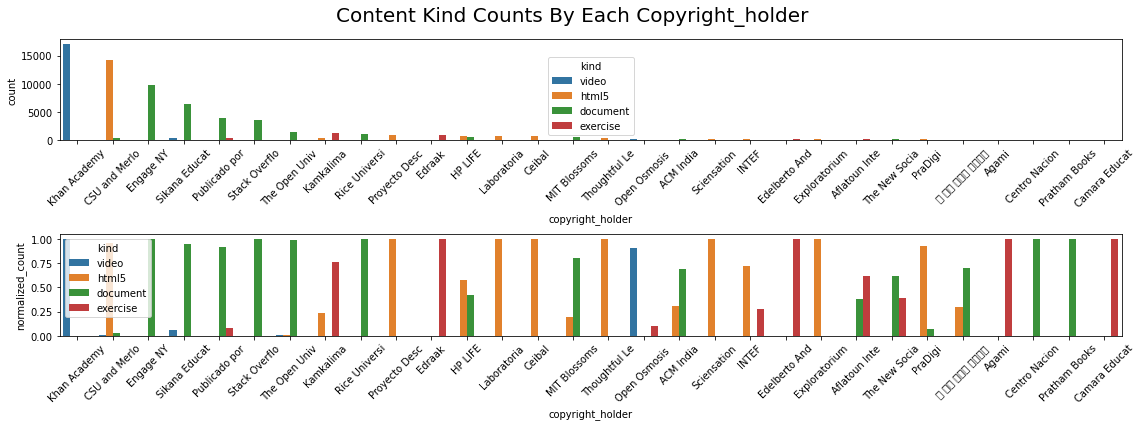

In [29]:
# 저작권자별 콘텐츠 보유량 
cat_cat_dist(data=content, feat1="copyright_holder", feat2="kind", title="Content Kind Counts By Each Copyright_holder", 
             feat1_lim=30, figsize=(16,6), rotate=True, cut_xlabel=True)

# 칸아카데미가 비디오 영상이 가장 많고 CSI와 MERIO가 HTML5가 많다. 그 뒤로 문서자료는 ENgage NY가 가장많은 것을 볼 수 있다.

In [30]:
content

,id,title,description,kind,text,language,copyright_holder,license
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,None
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,None
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,None
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA
...,...,...,...,...,...,...,...,...
154042,c_fffcbdd4de8b,2. 12: Diffusion,NaN,html5,What will eventually happen to these dyes?\n\n...,en,CSU and Merlot,CC BY-NC-SA
154043,c_fffe15a2d069,Sommare facendo gruppi da 10,Sal somma 5+68 spezzando il 5 in un 2 e un 3.\n\n,video,NaN,it,NaN,None
154044,c_fffed7b0d13a,Introdução à subtração,Sal fala sobre o que significa subtrair. Os ex...,video,NaN,pt,NaN,None
154045,c_ffff04ba7ac7,SA of a Cone,NaN,video,NaN,en,NaN,None


In [31]:
content["title_len"] = content["title"].str.len()
content["description_len"] = content["description"].str.len()
content["text_len"] = content["text"].str.len()

content[["title_len", "description_len", "text_len"]].describe()

# 타이틀 길이는 최대 177, 중앙값은 33인 것을 볼 수 있다.
# description 길이는 최대 9710으로 중앙값 124에 비해 많이 치우쳐져 있고 분산이 250으로 높은 것을 볼 수 있다.
# 텍스트 길이의 경우도 높은 분산을 가지고 있는 것을 볼 수 있다.

,title_len,description_len,text_len
count,154038.000000,89456.000000,74035.000000
mean,33.829782,124.291249,10531.613440
std,18.106550,250.144003,18016.019783
min,1.000000,1.000000,1.000000
25%,21.000000,51.000000,1853.000000
50%,31.000000,82.000000,4486.000000
75%,44.000000,122.000000,10016.000000
max,177.000000,9710.000000,100000.000000


### Topics

In [32]:
topic.head()

,id,title,description,channel,category,level,language,parent,has_content
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True


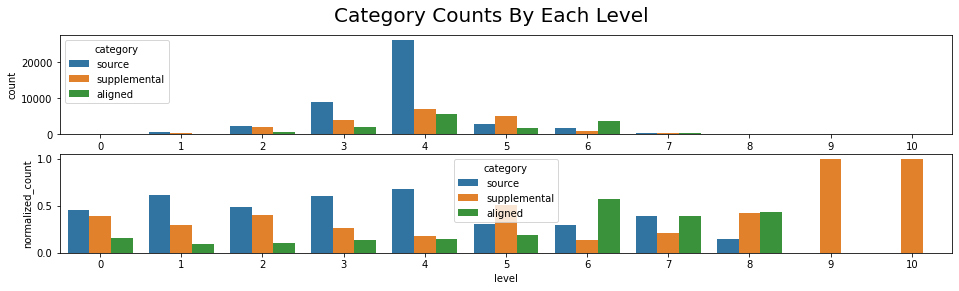

In [33]:
# 토픽의 각 레벨별 카테고리 횟수
cat_cat_dist(data=topic, feat1="level", feat2="category", title="Category Counts By Each Level")
# 4뎁스가 가장 많은 것을 볼 수 있고, alingned데이터가 가장 적은 것을 볼 수 있다.

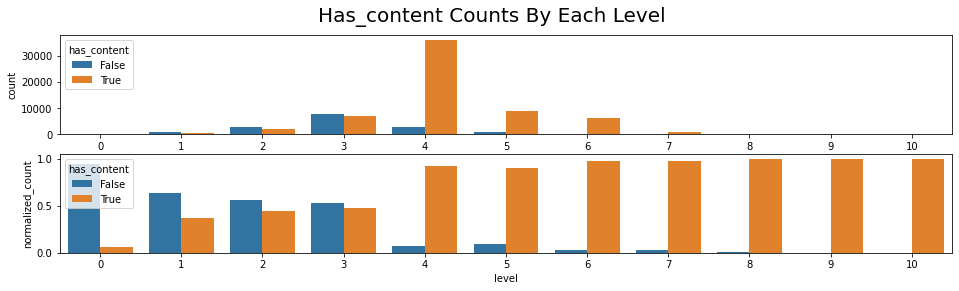

In [34]:
# 각 레벨별 Has_content 횟수
cat_cat_dist(data=topic, feat1="level", feat2="has_content", title="Has_content Counts By Each Level")
# Has_count 토픽과 연관된 content가 True인 것들이 가장 많은 것을 볼 수 있다.

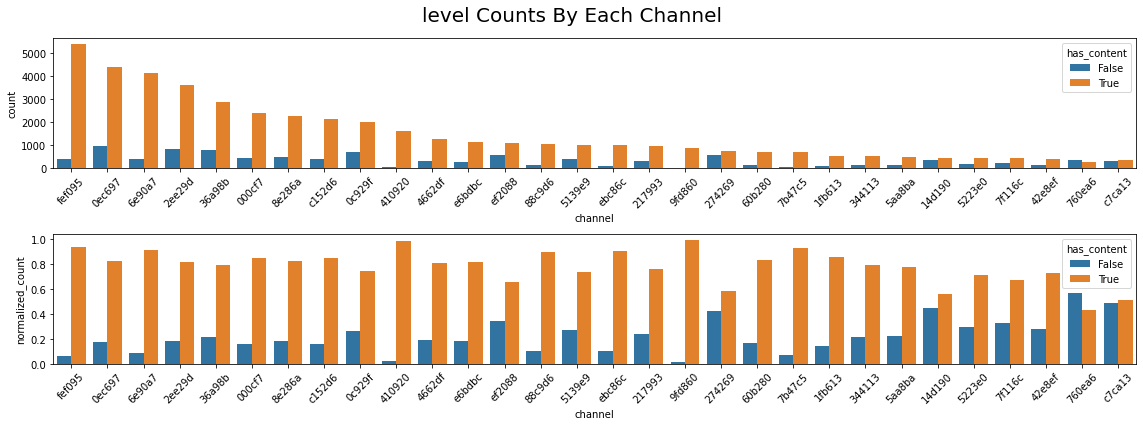

In [35]:
# 각 토픽트리별 has_count의 횟수
cat_cat_dist(data=topic, feat1="channel", feat2="has_content", title="level Counts By Each Channel",
             feat1_lim=30, figsize=(16,6), rotate=True, cut_xlabel=True)

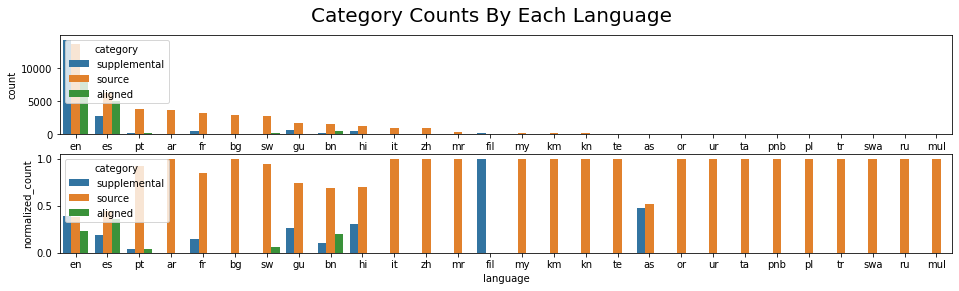

In [36]:
# 각 언어별 카테고리 횟수
# 영어가 가장 많음
cat_cat_dist(data=topic, feat1="language", feat2="category", title="Category Counts By Each Language")

In [37]:
# 카테고리가 source가 아닌것들의 언어 비율
topic.loc[topic["category"]!="source", "language"].value_counts()

en     22549
es      7733
bn       670
gu       608
fr       552
hi       541
pt       343
fil      247
sw       162
as        80
Name: language, dtype: int64

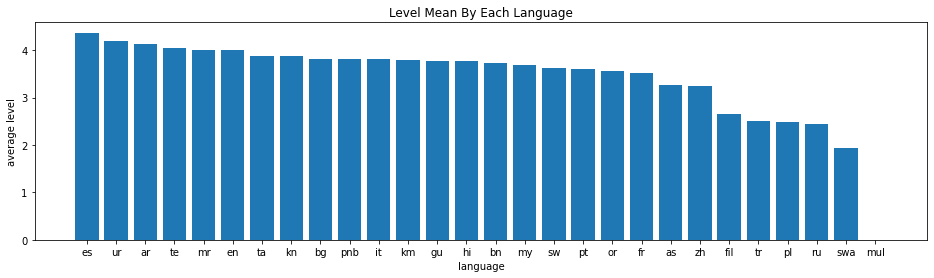

In [38]:
# 각 언어별 뎁스의 평균
topic_l_l = topic.groupby("language", as_index=False).agg({"level":"mean"})
topic_l_l.sort_values("level", inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(16, 4))
ax.bar(topic_l_l["language"], topic_l_l["level"]);
ax.set_title("Level Mean By Each Language")
ax.set_xlabel("language")
ax.set_ylabel("average level");

In [39]:
topic["title_len"] = topic["title"].str.len()
topic["description_len"] = topic["description"].str.len()

topic[["title_len", "description_len"]].describe()

,title_len,description_len
count,76970.000000,34953.000000
mean,26.780343,180.194118
std,17.413044,239.347045
min,1.000000,1.000000
25%,14.000000,63.000000
50%,23.000000,121.000000
75%,36.000000,226.000000
max,200.000000,4934.000000


## Exploration The Trees

In [40]:
# 트리별 분석
def get_tree_analysis(channel="fef095", language="en", parent=None):
    if parent is not None:
        condition = ((topic["channel"]==channel)&(topic["language"]==language)&(topic["parent"]==parent))
    else:
        condition = ((topic["channel"]==channel)&(topic["language"]==language))
    part_topic = topic.loc[condition, :].copy()
    part_topic = part_topic.merge(correlations, left_on="id", right_on="topic_id")
    part_topic["count"] = 1
    print(10*"-"+ " channel: " + channel + " " + 10*"-")
    print("id nunique: ", part_topic["id"].nunique())
    print("parent nunique: ", part_topic["parent"].nunique())
    
    content_counts = {
        'kind': {'video':0, 
                 'document':0, 
                 'html5':0, 
                 'exercise':0, 
                 'audio':0},
        'license': {"None":0, 
                    'CC BY-NC-ND':0, 
                    'CC BY-NC-SA':0, 
                    'Public Domain':0, 
                    'CC BY':0,
                    'CC BY-SA':0, 
                    'CC BY-NC':0, 
                    'CC BY-ND':0},
        'language': {'es': 0, 'it': 0, 'pt': 0, 'en': 0, 'mr': 0, 'bg': 0, 'gu': 0, 'sw': 0, 'hi': 0,
                     'ar': 0, 'bn': 0, 'as': 0, 'zh': 0, 'fr': 0, 'km': 0, 'pl': 0, 'ta': 0, 'fil': 0,
                     'or': 0, 'ru': 0, 'kn': 0, 'swa': 0, 'my': 0, 'pnb': 0, 'tr': 0, 'te': 0, 'ur': 0},
    }
    for index,row in part_topic.iterrows():
        for content_id in row["content_ids"].split(" "):
            part_content = content.loc[content["id"]==content_id, :]
            part_content.fillna("None", inplace=True)
            content_counts['kind'][part_content["kind"].values[0]] += 1
            content_counts['license'][part_content["license"].values[0]] += 1
            content_counts['language'][part_content["language"].values[0]] += 1
    
    #fig, axes = plt.subplots(5, figsiI’m going ze=(16,16))
    fig = plt.figure(figsize=(16, 6)) # initialize figure
    axes = [None for _ in range(5)] # list to save many ax for setting parameter in each
    axes[0] = plt.subplot2grid((3,4), (0,0), colspan=1)
    axes[1] = plt.subplot2grid((3,4), (0,1), colspan=3)
    axes[2] = plt.subplot2grid((3,4), (1,0), colspan=1)
    axes[3] = plt.subplot2grid((3,4), (1,1), colspan=3)
    axes[4] = plt.subplot2grid((3,4), (2,0), colspan=4)
    
    
    # Category
    part_topic_temp = part_topic.groupby("category", as_index=False).agg({"count":"sum"})
    part_topic_temp.sort_values("count", inplace=True, ascending=False)
    axes[0].bar(part_topic_temp["category"], part_topic_temp["count"]);
    axes[0].set_title("Count By Each Category")
    axes[0].set_xlabel("category")
    axes[0].set_ylabel("count");
    
    # Kind
    content_kind = pd.Series(content_counts["kind"])
    content_kind.sort_values(inplace=True, ascending=False)
    axes[1].bar(content_kind.index, content_kind.values);
    axes[1].set_title("Count By Each Kind")
    axes[1].set_xlabel("kind")
    axes[1].set_ylabel("count");
    
    # Level
    part_topic_temp = part_topic.groupby("level", as_index=False).agg({"count":"sum"})
    part_topic_temp.sort_values("count", inplace=True, ascending=False)
    axes[2].bar(part_topic_temp["level"], part_topic_temp["count"]);
    axes[2].set_title("Count By Each Level")
    axes[2].set_xlabel("level")
    axes[2].set_ylabel("count");
    
    # License
    content_kind = pd.Series(content_counts["license"])
    content_kind.sort_values(inplace=True, ascending=False)
    axes[3].bar(content_kind.index, content_kind.values);
    axes[3].set_title("Count By Each License")
    axes[3].set_xlabel("license")
    axes[3].set_ylabel("count");
    
    # Language
    content_kind = pd.Series(content_counts["language"])
    content_kind.sort_values(inplace=True, ascending=False)
    axes[4].bar(content_kind.index, content_kind.values);
    axes[4].set_title("Count By Each Language")
    axes[4].set_xlabel("language")
    axes[4].set_ylabel("count");
    
    fig.tight_layout()

---------- channel: af86ca ----------
id nunique:  5
parent nunique:  1


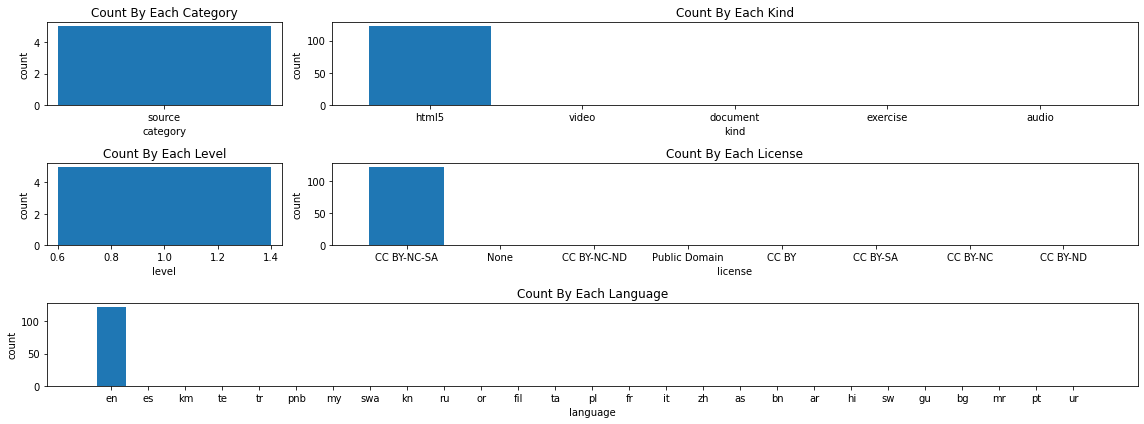

In [41]:
# 트리, 언어별 분석
get_tree_analysis(channel="af86ca", language="en")

# 채널이 af86ca이고 언어가 영어인 경우 html5 파일이 가장 많고, cc by nc sa 라이센스가 가장 많다.

---------- channel: fef095 ----------
id nunique:  112
parent nunique:  1


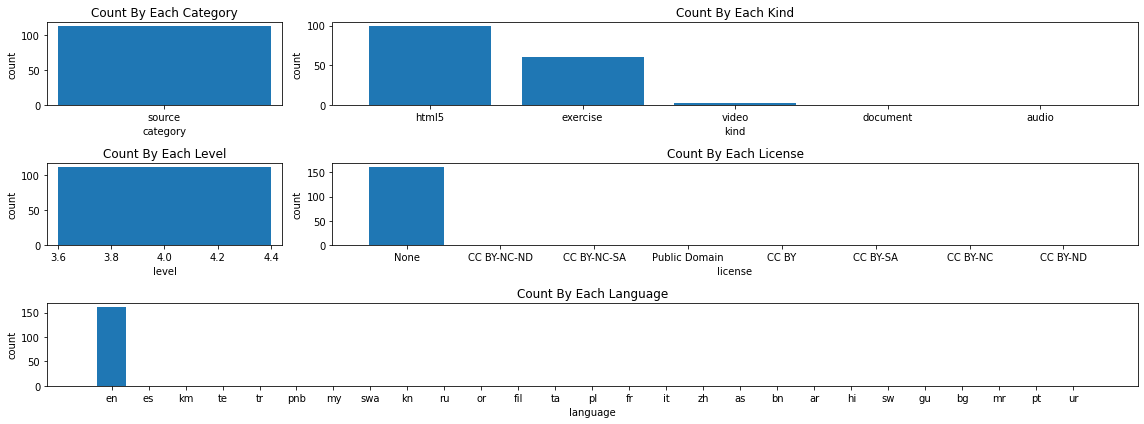

In [42]:
# 부모 노드가 't_009fc1677c8e'로 자식노드인 fef095의 영어인 경우 분석
get_tree_analysis(channel="fef095", language="en", parent="t_009fc1677c8e")

# 라이센스가 없으며, html5와 문제가 뒤이어서 많음

---------- channel: fef095 ----------
id nunique:  5394
parent nunique:  308


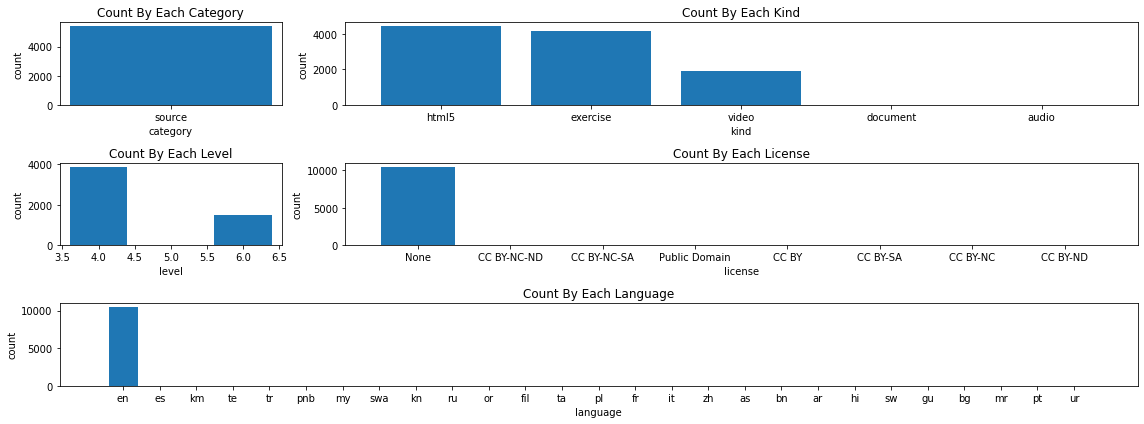

In [43]:
# fef095이면서 부모 노드가 없는 경우 분석
get_tree_analysis(channel="fef095", language="en", parent=None)

# html, exercise가 많으며, 라이센스가 없음 그리고 각 레벨 뎁스가 4, 6인 경우가 가장 많은것을 볼 수 있음

## F2 Metric Analysis

β = 1 (F1-Score)

β = 2 (F2-Score)

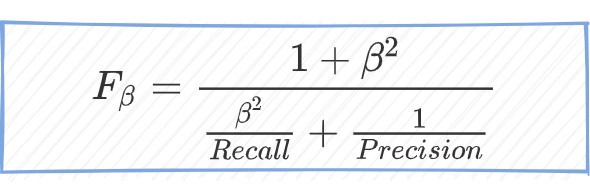

ref: https://towardsdatascience.com/is-f1-the-appropriate-criterion-to-use-what-about-f2-f3-f-beta-4bd8ef17e285

In [44]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

SAMPLE_NUM = 1000
y_true = list(np.random.choice([0, 1], SAMPLE_NUM-2, p=[0.75, 0.25]))
y_true.extend([0, 1])
y_pred_zero = list(np.zeros(SAMPLE_NUM-2).astype(int))
y_pred_zero.extend([1, 1])
y_pred_one = list(np.ones(SAMPLE_NUM-2).astype(int))
y_pred_one.extend([0, 0])

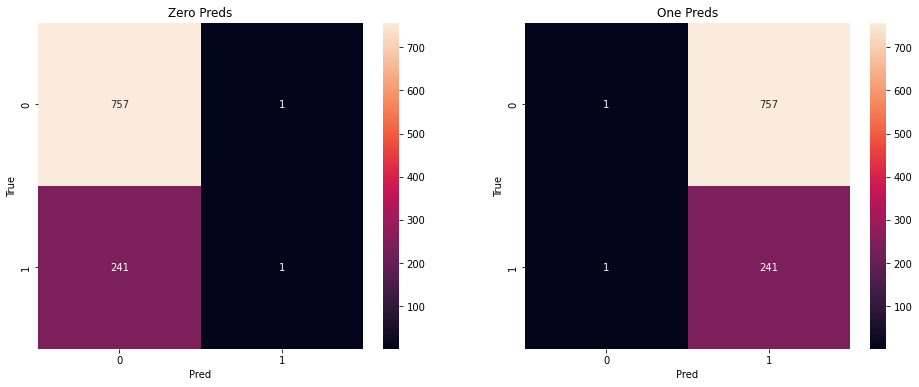

In [45]:
confusion_matrix_zero = confusion_matrix(y_true, y_pred_zero)
confusion_matrix_one = confusion_matrix(y_true, y_pred_one)

fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(confusion_matrix_zero, annot=True, ax=axes[0], fmt="g")
sns.heatmap(confusion_matrix_one, annot=True, ax=axes[1], fmt="g")
axes[0].set_title("Zero Preds")
axes[0].set_xlabel("Pred")
axes[0].set_ylabel("True")
axes[1].set_title("One Preds");
axes[1].set_xlabel("Pred")
axes[1].set_ylabel("True");

In [46]:
# 성능평가 지표
f1_score_zero = fbeta_score(y_true, y_pred_zero, beta=1)
f2_score_zero = fbeta_score(y_true, y_pred_zero, beta=2)
recall_score_zero = recall_score(y_true, y_pred_zero)
precision_score_zero = precision_score(y_true, y_pred_zero)

f1_score_one = fbeta_score(y_true, y_pred_one, beta=1)
f2_score_one = fbeta_score(y_true, y_pred_one, beta=2)
recall_score_one = recall_score(y_true, y_pred_one)
precision_score_one = precision_score(y_true, y_pred_one)

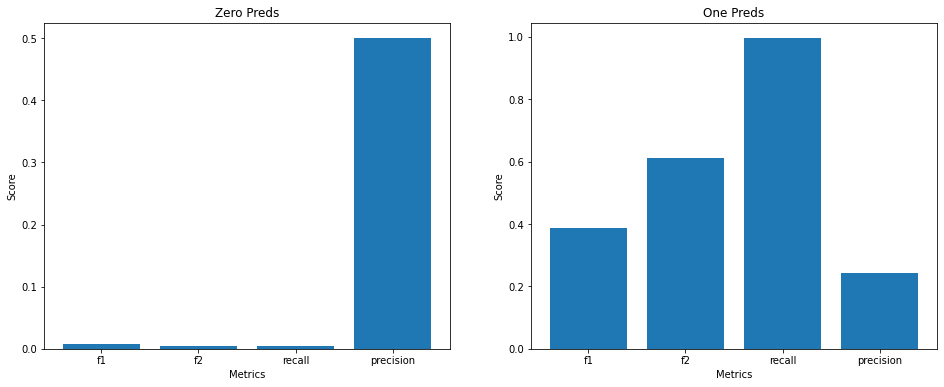

In [47]:
x_labels = ["f1", "f2", "recall", "precision"]
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].bar(x_labels, [f1_score_zero, f2_score_zero, recall_score_zero, precision_score_zero])
axes[1].bar(x_labels, [f1_score_one, f2_score_one, recall_score_one, precision_score_one])
axes[0].set_title("Zero Preds")
axes[0].set_xlabel("Metrics")
axes[0].set_ylabel("Score")
axes[1].set_title("One Preds");
axes[1].set_xlabel("Metrics")
axes[1].set_ylabel("Score");

## Feature Engineering

In [48]:
def add_spacy_features():
    !python -m spacy download es_core_news_sm
    !python -m spacy download fr_core_news_sm
    !python -m spacy download pt_core_news_sm
    !python -m spacy download zh_core_web_sm
    !python -m spacy download it_core_news_sm
    !python -m spacy download pl_core_news_sm
    !python -m spacy download ru_core_news_sm
    !python -m spacy download xx_ent_wiki_sm
    
    spacy_language_map = {
        "en":"en_core_web_sm",
        "es":"es_core_news_sm",
        "fr":"fr_core_news_sm",
        "pt":"pt_core_news_sm",
        "ar":"",
        "bg":"",
        "hi":"",
        "zh":"zh_core_web_sm",
        "gu":"",
        "bn":"",
        "sw":"",
        "it":"it_core_news_sm",
        "mr":"",
        "as":"",
        "fil":"",
        "km":"",
        "kn":"",
        "swa":"",
        "or":"",
        "pl":"pl_core_news_sm",
        "te":"",
        "ur":"",
        "tr":"",
        "ta":"",
        "my":"",
        "ru":"ru_core_news_sm",
        "pnb":"",
        "mul":"xx_ent_wiki_sm"
    }
    
    # content
    df_content_list = []
    for language, content_lan in content.groupby("language"):
        if spacy_language_map[language] == "":
            continue
        nlp = spacy.load(spacy_language_map[language])

        df_content = pd.DataFrame()
        df_content["id"] = ''
        df_content["title_POS"] = ''
        df_content["title_LEMMA"] = ''
        df_content["title_LABEL"] = ''
        df_content["description_POS"] = ''
        df_content["description_LEMMA"] = ''
        df_content["description_LABEL"] = ''
        for index, text in content_lan[['id', 'title', 'description', 'text']].iterrows():
            if type(text["title"]) == type(""):
                pos = get_pos(text["title"], model=nlp)
                lemma = get_lemma(text["title"], model=nlp)
                label = get_label(text["title"], model=nlp)
                # 형태소 분석
                df_content.loc[index, 'id'] = text["id"]
                df_content.loc[index, 'title_POS'] = ' '.join(pos)
                df_content.loc[index, 'title_LEMMA'] = ' '.join(lemma)
                df_content.loc[index, 'title_LABEL'] = ' '.join(label)

            if type(text["description"]) == type(""):
                pos = get_pos(text["description"], model=nlp)
                lemma = get_lemma(text["description"], model=nlp)
                label = get_label(text["description"], model=nlp)

                df_content.loc[index, 'description_POS'] = ' '.join(pos)
                df_content.loc[index, 'description_LEMMA'] = ' '.join(lemma)
                df_content.loc[index, 'description_LABEL'] = ' '.join(label)

        df_content["language"] = language
        df_content_list.append(df_content)
    df_content_all = pd.concat(df_content_list)
    df_content_all.to_csv("content_advanced.csv", index=False)
    
    # topics
    df_topic_list = []
    for language, topic_lan in topic.groupby("language"):
        if spacy_language_map[language] == "":
            continue
        nlp = spacy.load(spacy_language_map[language])

        df_topic = pd.DataFrame()
        df_topic["id"] = ''
        df_topic["title_POS"] = ''
        df_topic["title_LEMMA"] = ''
        df_topic["title_LABEL"] = ''
        df_topic["description_POS"] = ''
        df_topic["description_LEMMA"] = ''
        df_topic["description_LABEL"] = ''
        for index, text in topic_lan[['id', 'title', 'description']].iterrows():
            if type(text["title"]) == type(""):
                pos = get_pos(text["title"], model=nlp)
                lemma = get_lemma(text["title"], model=nlp)
                label = get_label(text["title"], model=nlp)

                df_topic.loc[index, 'id'] = text["id"]
                df_topic.loc[index, 'title_POS'] = ' '.join(pos)
                df_topic.loc[index, 'title_LEMMA'] = ' '.join(lemma)
                df_topic.loc[index, 'title_LABEL'] = ' '.join(label)

            if type(text["description"]) == type(""):
                pos = get_pos(text["description"], model=nlp)
                lemma = get_lemma(text["description"], model=nlp)
                label = get_label(text["description"], model=nlp)

                df_topic.loc[index, 'description_POS'] = ' '.join(pos)
                df_topic.loc[index, 'description_LEMMA'] = ' '.join(lemma)
                df_topic.loc[index, 'description_LABEL'] = ' '.join(label)

        df_topic["language"] = language
        df_topic_list.append(df_topic)
    df_topic_all = pd.concat(df_topic_list)
    df_topic_all.to_csv("topics_advanced.csv", index=False)

In [49]:
# 어근, 형태소,개체명 인식 
content_advanced = pd.read_csv("/kaggle/input/learningequality-advanceddataset/content_advanced.csv")
topics_advanced = pd.read_csv("/kaggle/input/learningequality-advanceddataset/topics_advanced.csv")
license_limitations = pd.read_csv("/kaggle/input/learningequality-advanceddataset/license_limitations.csv")

display(content_advanced.head())
display(topics_advanced.head())

,id,title_POS,title_LEMMA,title_LABEL,description_POS,description_LEMMA,description_LABEL,language
0,c_00019840d110,NUM PUNCT NOUN ADP DET PROPN NOUN,5.12e : regulation of the Calvin cycle,NaN,NaN,NaN,NaN,en
1,c_00027d03ca7d,NUM PUNCT PROPN CCONJ PROPN PUNCT PROPN PUNCT,4.e : Genomes and Chromosomes ( Exercises ),NaN,NaN,NaN,NaN,en
2,c_000425df0161,X PUNCT PROPN PROPN PROPN PROPN ADP NOUN,9.3 : Van Der Waals Forces between atom,CARDINAL,NaN,NaN,NaN,en
3,c_00046806ad8a,VERB ADJ ADJ ADJ NOUN,compare multi - digit number,NaN,VERB PRON NOUN NOUN NOUN PART VERB VERB ADJ NO...,use your place value skill to practice compare...,NaN,en
4,c_000751f58836,NOUN ADP NOUN NOUN PUNCT NOUN NUM PUNCT,tangent of circle problem ( example 2 ),CARDINAL,PROPN VERB DET VERB NOUN VERB DET NOUN PRON NO...,Sal find a miss angle use the property that ta...,NaN,en


,id,title_POS,title_LEMMA,title_LABEL,description_POS,description_LEMMA,description_LABEL,language
0,t_000095e03056,NOUN NUM NOUN CCONJ NOUN,unit 3.3 enlargement and similarity,ORG,NaN,NaN,NaN,en
1,t_00069b63a70a,NOUN,transcript,NaN,NaN,NaN,NaN,en
2,t_0008a1bd84ba,NUM PUNCT NUM PUNCT PROPN PROPN,12 . 20 : Bird Reproduction,CARDINAL CARDINAL,NaN,NaN,NaN,en
3,t_000c0c854f0b,PROPN,Nepal,NaN,NaN,NaN,NaN,en
4,t_000d1fb3f2f5,NUM PUNCT PROPN,2.1.2 - Logarithms,ORG,NaN,NaN,NaN,en


In [50]:
content[content['id']=='c_000425df0161']

,id,title,description,kind,text,language,copyright_holder,license,title_len,description_len,text_len
10,c_000425df0161,9.3: Van Der Waals Forces between Atoms,NaN,html5,Introduction\n\nThe perfect gas equation of st...,en,CSU and Merlot,CC BY-NC-SA,39.0,NaN,10868.0


In [51]:
# 라이센스별 조건
license_limitations

,license,Credit must be given to the creator,Adaptations must be shared under the same terms,Only noncommercial uses of the work are permitted,No derivatives or adaptations of the work are permitted
0,CC BY,True,False,False,False
1,CC BY-ND,True,False,False,True
2,CC BY-SA,True,True,False,False
3,CC BY-NC,True,False,True,False
4,CC BY-NC-SA,True,True,True,False
5,CC BY-NC-ND,True,False,True,True
6,Public Domain,False,False,False,False


In [52]:
print("content_advanced shape:", content_advanced.shape)
print("topics_advanced shape:", topics_advanced.shape)

content_advanced shape: (123550, 8)
topics_advanced shape: (59757, 8)


In [53]:
print("content_advanced nan value sum:", content_advanced.isna().sum().sum())
print("topics_advanced nan value sum:", topics_advanced.isna().sum().sum())

content_advanced nan value sum: 262717
topics_advanced nan value sum: 153103


# Validation

In [54]:
BASE_DIR = "/kaggle/input/learning-equality-curriculum-recommendations/"
content = pd.read_csv(BASE_DIR+"content.csv")
correlations = pd.read_csv(BASE_DIR+"correlations.csv")
topic = pd.read_csv(BASE_DIR+"topics.csv")
sub = pd.read_csv(BASE_DIR+"sample_submission.csv")

# 콘텐츠 데이터에 라이센스별 조건을 붙이고 결측치 처리
content = content.merge(license_limitations, on="license", how="left")
content["license_nan"] = content["license"].isna()
gc.collect()

53586

In [55]:
# 라이센스별로 라이센스 조건을 붙이고, 결측치 처리, 그리고 타이틀과, 요약의 형태소, 어근, 개체명을 분석 결과 결측치 처리
# 토픽에는 제목과 요약본을 합쳐서 'merged_text' 만듦
license_cols = ["license_nan", "Credit must be given to the creator", "Adaptations must be shared under the same terms", 
                "Only noncommercial uses of the work are permitted", "No derivatives or adaptations of the work are permitted"]
content[["title", "description", "text"]] = content[["title", "description", "text"]].fillna("")
content[license_cols] = content[license_cols].fillna(False)
topic[["title", "description"]] = topic[["title", "description"]].fillna("")

advanced_cols = ['title_POS', 'title_LEMMA', 'title_LABEL', 'description_POS',
                 'description_LEMMA', 'description_LABEL']
content_advanced[advanced_cols] = content_advanced[advanced_cols].fillna("")
topics_advanced[advanced_cols] = topics_advanced[advanced_cols].fillna("")

topic["merged_text"] = topic['title']+', '+topic['description']
content["merged_text"] = content['title']+', '+content['description']

In [56]:
topic.head()

,id,title,description,channel,category,level,language,parent,has_content,merged_text
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True,"Откриването на резисторите, Изследване на мате..."
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,,b3f329,aligned,2,en,t_aa32fb6252dc,False,"Unit 3.3 Enlargements and Similarities,"
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True,"Entradas e saídas de uma função, Entenda um po..."
3,t_00069b63a70a,Transcripts,,6e3ba4,source,3,en,t_4054df11a74e,True,"Transcripts,"
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True,Графики на експоненциални функции (Алгебра 2 н...


In [57]:
content.head()

,id,title,description,kind,text,language,copyright_holder,license,Credit must be given to the creator,Adaptations must be shared under the same terms,Only noncommercial uses of the work are permitted,No derivatives or adaptations of the work are permitted,license_nan,merged_text
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,,es,NaN,NaN,False,False,False,False,True,"Sumar números de varios dígitos: 48,029+233,93..."
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,,it,NaN,NaN,False,False,False,False,True,"Trovare i fattori di un numero, Sal trova i fa..."
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,,es,NaN,NaN,False,False,False,False,True,"Sumar curvas de demanda, Cómo añadir curvas de..."
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND,True,False,True,True,False,"Nado de aproximação, Neste vídeo você vai apre..."
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA,True,True,True,False,False,"geometry-m3-topic-a-overview.pdf, geometry-m3-..."


In [58]:
content_advanced

,id,title_POS,title_LEMMA,title_LABEL,description_POS,description_LEMMA,description_LABEL,language
0,c_00019840d110,NUM PUNCT NOUN ADP DET PROPN NOUN,5.12e : regulation of the Calvin cycle,,,,,en
1,c_00027d03ca7d,NUM PUNCT PROPN CCONJ PROPN PUNCT PROPN PUNCT,4.e : Genomes and Chromosomes ( Exercises ),,,,,en
2,c_000425df0161,X PUNCT PROPN PROPN PROPN PROPN ADP NOUN,9.3 : Van Der Waals Forces between atom,CARDINAL,,,,en
3,c_00046806ad8a,VERB ADJ ADJ ADJ NOUN,compare multi - digit number,,VERB PRON NOUN NOUN NOUN PART VERB VERB ADJ NO...,use your place value skill to practice compare...,,en
4,c_000751f58836,NOUN ADP NOUN NOUN PUNCT NOUN NUM PUNCT,tangent of circle problem ( example 2 ),CARDINAL,PROPN VERB DET VERB NOUN VERB DET NOUN PRON NO...,Sal find a miss angle use the property that ta...,,en
...,...,...,...,...,...,...,...,...
123545,c_ff99e9274a3a,NOUN NOUN NOUN,,QUANTITY,NOUN ADV VERB NOUN NOUN NOUN,,QUANTITY,zh
123546,c_ffae7a5c46e1,ADV ADJ NOUN NOUN NOUN VERB VERB ADV VERB PART...,,,ADV ADJ NOUN NOUN NOUN VERB VERB ADV VERB PART...,,,zh
123547,c_ffae9307b1ff,VERB,,,ADP DET NOUN PART PUNCT PRON ADV VERB VERB PAR...,,,zh
123548,c_ffd356011575,NOUN ADV ADV ADJ NOUN PART VERB,,,PROPN NOUN PART NOUN NOUN ADV VERB PRON PART N...,,GPE,zh


## Sklearn

In [59]:
!pip install kneed

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA

In [61]:
# 배치에서 코사인 거리를 계산한다.
def pairwise_distances_on_batch(topic, content, metric='cosine', n_jobs=-1, batch_size=1000, n_rec=5):
    cos_dist_list = []
    for i in range(int(topic.shape[0] / batch_size)+1):
        cos_dist_part = pairwise_distances(topic[i*batch_size:i*batch_size+batch_size], 
                                           content, metric=metric, n_jobs=n_jobs)
        cos_dist_part = cos_dist_part.argsort(axis=1)
        print(f"X_topic_nmf_part.shape: {topic[i*batch_size:i*batch_size+batch_size].shape} - cos_dist_part.shape: {cos_dist_part[:, :n_rec].shape}")
        cos_dist_list.append(cos_dist_part[:, :n_rec])
        del cos_dist_part
        gc.collect()
    cos_dist = np.vstack(tuple(cos_dist_list))
    return cos_dist


# sklearn 베이스라인 예측값 도출
def get_sklearn_baseline_preds(advanced_feat=True, drop_source=False, drop_copyright_holder=False, 
                      tree_coef=1.0, kind_coef=1.0, n_rec=100):
    # 토픽 언어의 유니크한 값 구함
    topics_advanced_lan_unique = topics_advanced["language"].unique()
    all_preds_list = []
    # 토픽을 언어별로 그룹바이한 데이터를 순회한다.
    for language, group in topic.groupby("language"):
        print("language: ", language)
        # 만약 언어가 mul이라면 계속하고
        if language == "mul":
            continue
        # 만약 언어가 유니크한 값에 있거나 True값이라면
        if language in topics_advanced_lan_unique and advanced_feat:
            # content advanced, topics advanced  데이터 프레임에서 해당 언어 데이터를 가져온다
            content_advanced_part = content_advanced.loc[content["language"]==language,:]
            topics_advanced_part = topics_advanced.loc[topic["language"]==language,:]
            content_advanced_part.reset_index(inplace=True, drop=True)
            topics_advanced_part.reset_index(inplace=True, drop=True)
            
            # 토픽과 컨텐츠의 제목과 요약의 어근, 개체명을 하나로 합친다.
            topics_advanced_part["merged_text_LEMMA"] = topics_advanced['title_LEMMA']+', '+topics_advanced['description_LEMMA']
            topics_advanced_part["merged_text_LABEL"] = topics_advanced['title_LABEL']+', '+topics_advanced['description_LABEL']
            content_advanced_part["merged_text_LEMMA"] = content_advanced['title_LEMMA']+', '+content_advanced['description_LEMMA']
            content_advanced_part["merged_text_LABEL"] = content_advanced['title_LABEL']+', '+content_advanced['description_LABEL']
            
            # 어근과 텍스트의 TFIDF 벡터를 만든다.
            vectorizer_lemma = TfidfVectorizer(max_features=10000)
            X_topic_lemma = vectorizer_lemma.fit_transform(topics_advanced_part["merged_text_LEMMA"]).toarray()
            X_content_lemma = vectorizer_lemma.transform(content_advanced_part["merged_text_LEMMA"]).toarray()
            print(f"X_content_lemma.shape: {X_content_lemma.shape} - X_topic_lemma.shape: {X_topic_lemma.shape}")
            
             
            vectorizer_label = TfidfVectorizer(max_features=500)
            X_topic_label = vectorizer_label.fit_transform(topics_advanced_part["merged_text_LABEL"]).toarray() * 10
            X_content_label = vectorizer_label.transform(content_advanced_part["merged_text_LABEL"]).toarray() * 10
            print(f"X_content_label.shape: {X_content_label.shape} - X_content_label.shape: {X_topic_label.shape}")
            
            # TFIDF화 된 토픽, 컨텐츠의 어근과 라벨을 하나의 어레이로 합친다.
            X_topic = np.hstack((X_topic_lemma, X_topic_label))
            X_content = np.hstack((X_content_lemma, X_content_label))
            print(f"X_content.shape: {X_content.shape} - X_topic.shape: {X_topic.shape}")
            
            del X_topic_lemma, X_content_lemma, X_topic_label, X_content_label
            gc.collect()
            
            # 
            nmf_model = NMF(n_components=61)
            X_topic_nmf = nmf_model.fit_transform(X_topic)
            X_content_nmf = nmf_model.transform(X_content)
            print(f"X_content_nmf.shape: {X_content_nmf.shape} - X_topic_nmf.shape: {X_topic_nmf.shape}")

            del X_content, X_topic, nmf_model, vectorizer_lemma, vectorizer_label
            gc.collect()

            if X_topic_nmf.shape[0] > 4000:
                cos_dist = pairwise_distances_on_batch(X_topic_nmf, X_content_nmf, metric='cosine', 
                                                        n_jobs=-1, batch_size=4000, n_rec=n_rec)
            else: 
                cos_dist = pairwise_distances(X_topic_nmf, X_content_nmf, metric='cosine', n_jobs=-1)
                cos_dist = cos_dist.argsort(axis=1)
            print(f"cos_dist.shape: {cos_dist.shape}")
            df_preds = pd.DataFrame(columns=["topic_id", "content_ids"])
            for row_index in range(cos_dist.shape[0]):
                df_pred = content_advanced_part.loc[cos_dist[row_index], :]
                df_pred.dropna(inplace=True)
                df_pred.reset_index(inplace=True, drop=True)

                df_pred = df_pred.loc[:n_rec-1, :]
                preds = df_pred["id"].values
                
                preds_dict = {
                    "topic_id":topics_advanced_part.loc[row_index,"id"],
                    "content_ids":' '.join(list(preds))
                }
                df_preds = df_preds.append(preds_dict,ignore_index=True)

                del df_pred, preds, preds_dict
                gc.collect()

            all_preds_list.append(df_preds)
            del cos_dist, df_preds, content_advanced_part, topics_advanced_part
            gc.collect()
            
        else:
            content_part = content.loc[content["language"]==language,:]
            topic_part = topic.loc[topic["language"]==language,:]

            if drop_source:
                topic_part.loc[topic_part["category"]!="source",:]
            if drop_copyright_holder:
                content_part.loc[content_part["copyright_holder"]!=True,:]

            content_part.reset_index(inplace=True, drop=True)
            topic_part.reset_index(inplace=True, drop=True)
            
            vectorizer = TfidfVectorizer(max_features=10000)
            X_topic = vectorizer.fit_transform(topic_part["merged_text"]).toarray()
            X_content = vectorizer.transform(content_part["merged_text"]).toarray()
            print(f"X_content.shape: {X_content.shape} - X_topic.shape: {X_topic.shape}")
            
            # 비음수 행렬분해 실시하여 차원을 축소함
            nmf_model = NMF(n_components=61)
            X_topic_nmf = nmf_model.fit_transform(X_topic)
            X_content_nmf = nmf_model.transform(X_content)
            print(f"X_content_nmf.shape: {X_content_nmf.shape} - X_topic_nmf.shape: {X_topic_nmf.shape}")

            del X_content, X_topic, nmf_model, vectorizer
            gc.collect()
            
            # 만약 차원축소 된것의 데이터 갯수가 4000이 넘는다면 배치로 나누어서 유사도 진행
            if X_topic_nmf.shape[0] > 4000:
                cos_dist = pairwise_distances_on_batch(X_topic_nmf, X_content_nmf, metric='cosine', 
                                                        n_jobs=-1, batch_size=4000, n_rec=n_rec)
            else: 
                cos_dist = pairwise_distances(X_topic_nmf, X_content_nmf, metric='cosine', n_jobs=-1)
                cos_dist = cos_dist.argsort(axis=1)
            print(f"cos_dist.shape: {cos_dist.shape}")
            
            # 토픽 id, content id 데이터 프레임 만든다.
            df_preds = pd.DataFrame(columns=["topic_id", "content_ids"])
            # 코사인 유사도의 n_rec까지의 인덱스를 붙인다.
            for row_index in range(cos_dist.shape[0]):
                df_pred = content_part.loc[cos_dist[row_index], :]
                df_pred.dropna(inplace=True)
                df_pred.reset_index(inplace=True, drop=True)
                
                df_pred = df_pred.loc[:n_rec-1, :]
                preds = df_pred["id"].values

                preds_dict = {
                    "topic_id":topic_part.loc[row_index,"id"],
                    "content_ids":' '.join(list(preds))
                }
                df_preds = df_preds.append(preds_dict,ignore_index=True)

                del df_pred, preds, preds_dict
                gc.collect()

            all_preds_list.append(df_preds)
            del cos_dist, df_preds, content_part, topic_part
            gc.collect()
        
    return pd.concat(all_preds_list)

In [62]:
# 차원 축소시 최적의 요소를 찾기 위한 함수
def find_best_n_component():      
    from tqdm import tqdm
    from kneed import KneeLocator
    
    content_part = content.loc[content["language"]=="en",:]
    topic_part = topic.loc[topic["language"]=="en",:]
            
    content_part.reset_index(inplace=True, drop=True)
    topic_part.reset_index(inplace=True, drop=True)
        
    vectorizer = TfidfVectorizer(max_features=20000)
    X_topic = vectorizer.fit_transform(topic_part["merged_text"]).toarray()
    X_content = vectorizer.transform(content_part["merged_text"]).toarray()
    print(f"X_content.shape: {X_content.shape} - X_topic.shape: {X_topic.shape}")
    
    pca_model = PCA(n_components=1000)
    pca_model.fit(X_topic)
    
    kn = KneeLocator(np.arange(0, len(pca_model.explained_variance_ratio_)),
                 pca_model.explained_variance_ratio_, curve='convex', direction='decreasing')
    
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(np.arange(0, len(pca_model.explained_variance_ratio_)), pca_model.explained_variance_ratio_)
    ax.set_xlabel('N_Component')
    ax.set_ylabel('Explained Variance Ratio')
    ax.axvline(kn.knee+1, color="red", linestyle="--")
    ax.text(kn.knee+1, 0.01, s=f"n_component={kn.knee+1}")
    plt.show()
    
    del content_part, topic_part, vectorizer, X_topic, X_content
    gc.collect()

# 성능 평가 지표
def get_f2_score(df_true, df_pred, n_rec=5):
    df_true_pred = df_true.merge(df_pred, on="topic_id", how="left", suffixes=["_true", "_pred"])
    df_true_pred.fillna("c_dd739e116435", inplace=True)
    df_true_pred.head()
    
    f2_scores = np.zeros(len(df_true_pred))
    for index, row in df_true_pred.iterrows():
        true_ids = row["content_ids_true"].split(" ")
        pred_ids = row["content_ids_pred"].split(" ")
        pred_ids = pred_ids[:n_rec]
        
        true_positives = len(set(true_ids).intersection(set(pred_ids)))
        false_positives = len(set(pred_ids)-set(true_ids))
        false_negatives = len(set(true_ids)-set(pred_ids))

        beta = 2
        f2_score = ((1+beta**2)*true_positives)/((1+beta**2)*true_positives + beta**2*false_negatives + false_positives)
        f2_scores[index]=f2_score
    
    return f2_scores.mean()

X_content.shape: (65939, 15604) - X_topic.shape: (36161, 15604)


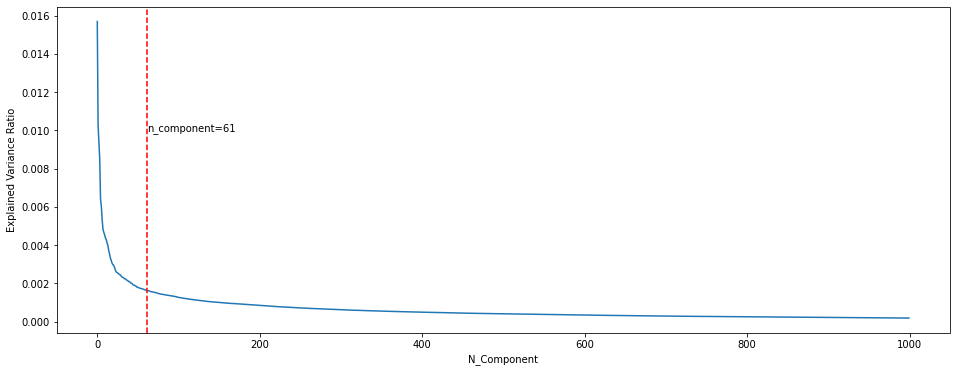

In [63]:
find_best_n_component()

In [64]:
#train_baseline_preds = get_sklearn_baseline_preds(advanced_feat=False)
#train_baseline_preds.to_csv("train_baseline_preds.csv", index=False)

train_baseline_preds = pd.read_csv("/kaggle/input/learningequality-advanceddataset/train_preds/train_baseline_preds.csv")
train_baseline_preds.head()

,topic_id,content_ids
0,t_0014d6945f7e,c_e50e1505b72c c_174c86757449 c_63b3421e1324 c...
1,t_00365ac4da76,c_5a87fbb0bd3e c_04a6a369e1dd c_fb729745bf5c c...
2,t_0080677f0953,c_bb04c9578e59 c_4c5d200ab6a7 c_fc0232f74d40 c...
3,t_00a2b86f7630,c_01cc3189a9ce c_15cb849ff61a c_a732baa82bee c...
4,t_00a899ec2a51,c_1d55d5e8217c c_ce31210be7bd c_d7f1dc6c69ba c...


In [65]:
f2_scores = []
for i in range(1, 101):
    f2_score = get_f2_score(correlations, train_baseline_preds, n_rec=i)
    f2_scores.append(f2_score)

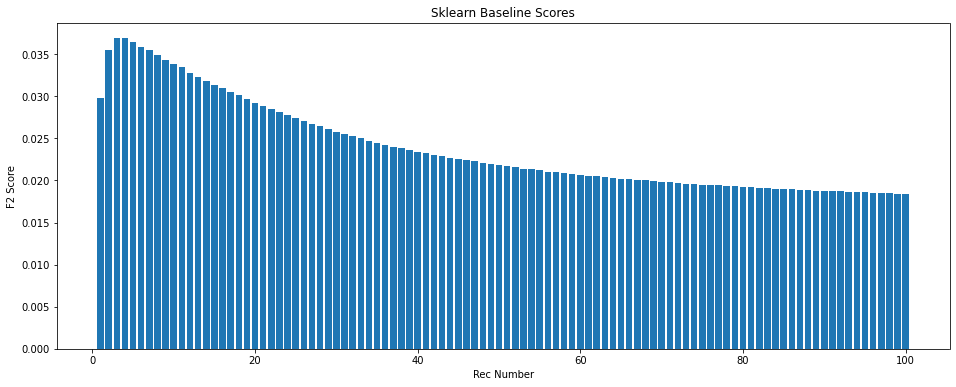

In [66]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(np.arange(1, 101), f2_scores)
ax.set_ylabel("F2 Score")
ax.set_xlabel("Rec Number")
ax.set_title("Sklearn Baseline Scores");

In [67]:
#train_baseline_advanced_preds = get_sklearn_baseline_preds(advanced_feat=True)
#train_baseline_advanced_preds.to_csv("train_baseline_advanced_preds.csv", index=False)

train_baseline_advanced_preds = pd.read_csv("/kaggle/input/learningequality-advanceddataset/train_preds/train_baseline_advanced_preds.csv")
train_baseline_advanced_preds.head()

,topic_id,content_ids
0,t_0014d6945f7e,c_e50e1505b72c c_174c86757449 c_63b3421e1324 c...
1,t_00365ac4da76,c_5a87fbb0bd3e c_04a6a369e1dd c_fb729745bf5c c...
2,t_0080677f0953,c_bb04c9578e59 c_4c5d200ab6a7 c_fc0232f74d40 c...
3,t_00a2b86f7630,c_01cc3189a9ce c_15cb849ff61a c_a732baa82bee c...
4,t_00a899ec2a51,c_1d55d5e8217c c_ce31210be7bd c_d7f1dc6c69ba c...


In [68]:
f2_scores_advanced = []
for i in range(1, 101):
    f2_score = get_f2_score(correlations, train_baseline_advanced_preds, n_rec=i)
    f2_scores_advanced.append(f2_score)

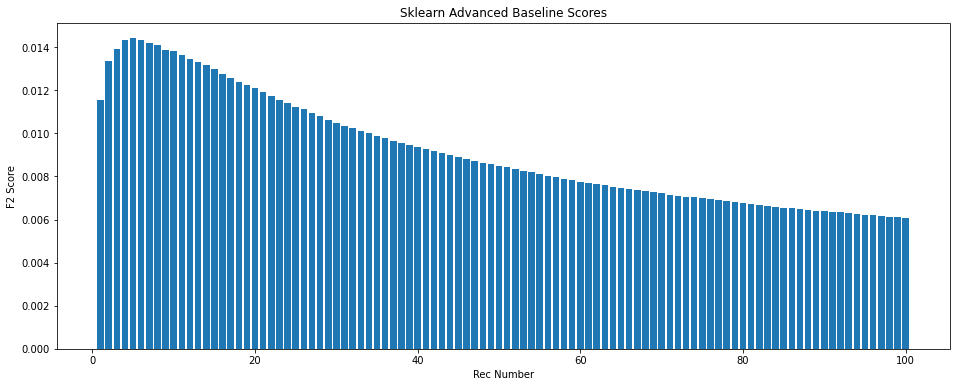

In [69]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(np.arange(1, 101), f2_scores_advanced)
ax.set_ylabel("F2 Score")
ax.set_xlabel("Rec Number")
ax.set_title("Sklearn Advanced Baseline Scores");

## Transformers

In [70]:
import transformers
from transformers import BertTokenizer, TFBertModel, BertModel
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm

2023-02-10 06:44:13.394487: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [71]:
# pretrain 함수 활용
tokenizer_word = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
tokenizer_sentence = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

model_word = BertModel.from_pretrained("bert-base-multilingual-cased")
model_sentence = AutoModel.from_pretrained("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/402 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/723 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

In [72]:
# 단어 토크나이징, 문장 토크나이징 인코딩진행
texts = ['This is an example sentence', 'Each sentence is converted']

encoded_input_word = tokenizer_word(texts, padding=True, truncation=True, return_tensors='pt') # return_tensors='tf' for TensorFlow, return_tensors='pt' for PyTorch
encoded_input_sentence = tokenizer_sentence(texts, padding=True, truncation=True, return_tensors='pt')

encoded_input_word

{'input_ids': tensor([[  101, 10747, 10124, 10151, 14351, 49219,   102],
        [  101, 23223, 49219, 10124, 30827,   102,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0]])}

In [73]:
# 출력 단어
model_output_word = model_word(
    encoded_input_word["input_ids"], 
    attention_mask=encoded_input_word["attention_mask"]
    ).last_hidden_state.mean(1)
model_output_word, model_output_word.shape

(tensor([[-0.1304, -0.6215,  0.3240,  ...,  0.1838,  0.0104,  0.0187],
         [ 0.1563, -0.3375, -0.0849,  ...,  0.7737,  0.3111, -0.2423]],
        grad_fn=<MeanBackward1>),
 torch.Size([2, 768]))

In [74]:
# 출력 문장
model_output_sentence = model_sentence(
    encoded_input_sentence["input_ids"], 
    attention_mask=encoded_input_sentence["attention_mask"]
    ).last_hidden_state.mean(1)
model_output_sentence, model_output_sentence.shape

(tensor([[ 0.1432, -0.2308, -0.0139,  ...,  0.0399,  0.1009, -0.1994],
         [ 0.0400, -0.2041, -0.0131,  ...,  0.0263, -0.2010, -0.1452]],
        grad_fn=<MeanBackward1>),
 torch.Size([2, 768]))

In [75]:
del tokenizer_word, tokenizer_sentence, model_word, model_sentence
gc.collect()

82

In [76]:
# 배치로 나누어서 임베딩 진행
def embedding_on_batch(texts, model, batch_size=500):
    embedding_list = []
    for i in range(int(texts["input_ids"].shape[0] / batch_size)+1):
        with torch.no_grad():
            embedding_part = model(
                    texts["input_ids"][i*batch_size:i*batch_size+batch_size], 
                    attention_mask=texts["attention_mask"][i*batch_size:i*batch_size+batch_size]
                ).last_hidden_state.mean(1)
            print(f"embedding_part.shape: {embedding_part.shape}")
            embedding_list.append(embedding_part.detach().numpy())
            del embedding_part
            gc.collect()
    embedding = np.vstack(tuple(embedding_list))
    return embedding

# 예측 진행
def get_transformer_preds(model_name="word", drop_source=False, drop_copyright_holder=False, n_rec=100):
    MAX_LENGTH = 64
    
    # 단어일경우
    if model_name == "word":
        tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
        model = BertModel.from_pretrained("bert-base-multilingual-cased")
    
    # 문장일 경우
    elif model_name == "sentence":
        tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
        model = transformers.AutoModel.from_pretrained("sentence-transformers/paraphrase-multilingual-mpnet-base-v2", trainable=False)
        for layer in model.layers:
            layer.trainable=False
            for w in layer.weights: w._trainable=False
    
    all_preds_list = []
    # 언어별로 예측 진행
    for language, group in topic.groupby("language"):
        print("language: ", language)
        if language == "mul":
            continue
        
        content_part = content.loc[content["language"]==language,:]
        topic_part = topic.loc[topic["language"]==language,:]
        
        # drop source가 True 이면 source를 제거하고 진행
        if drop_source:
            topic_part.loc[topic_part["category"]!="source",:]
        # drop copyright가 True이면 False인것들 제거하고 진행
        if drop_copyright_holder:
            content_part.loc[content_part["copyright_holder"]!=True,:]
            
        content_part.reset_index(inplace=True, drop=True)
        topic_part.reset_index(inplace=True, drop=True)
        
        # 토크나이징 진행
        X_token_topic = tokenizer(list(topic_part["merged_text"].values), padding="max_length", 
                                  truncation=True, return_tensors='pt', max_length=MAX_LENGTH)
        X_token_content = tokenizer(list(content_part["merged_text"].values), padding="max_length", 
                                    truncation=True, return_tensors='pt', max_length=MAX_LENGTH)
        print(f"X_token_topic.shape: {X_token_topic['input_ids'].shape} - X_token_content.shape: {X_token_content['input_ids'].shape}")
        
        del topic_part, content_part
        gc.collect()
        
        # 임베딩 진행
        X_embedding_topic = embedding_on_batch(X_token_topic, model, batch_size=4000)
        X_embedding_content = embedding_on_batch(X_token_content, model, batch_size=4000)
        print(f"X_embedding_topic.shape: {X_embedding_topic.shape} - X_embedding_content.shape: {X_embedding_content.shape}")
        
        del X_token_topic, X_token_content
        gc.collect()
        
        # 코사인 유사도 비교를 통해 정답 추출
        
        cos_dist = pairwise_distances_on_batch(X_embedding_topic, X_embedding_content, metric='cosine', 
                                                        n_jobs=-1, batch_size=4000, n_rec=n_rec)
        
        break

In [77]:
#get_transformer_preds(model_name="word")

# Modeling

# Working Progress

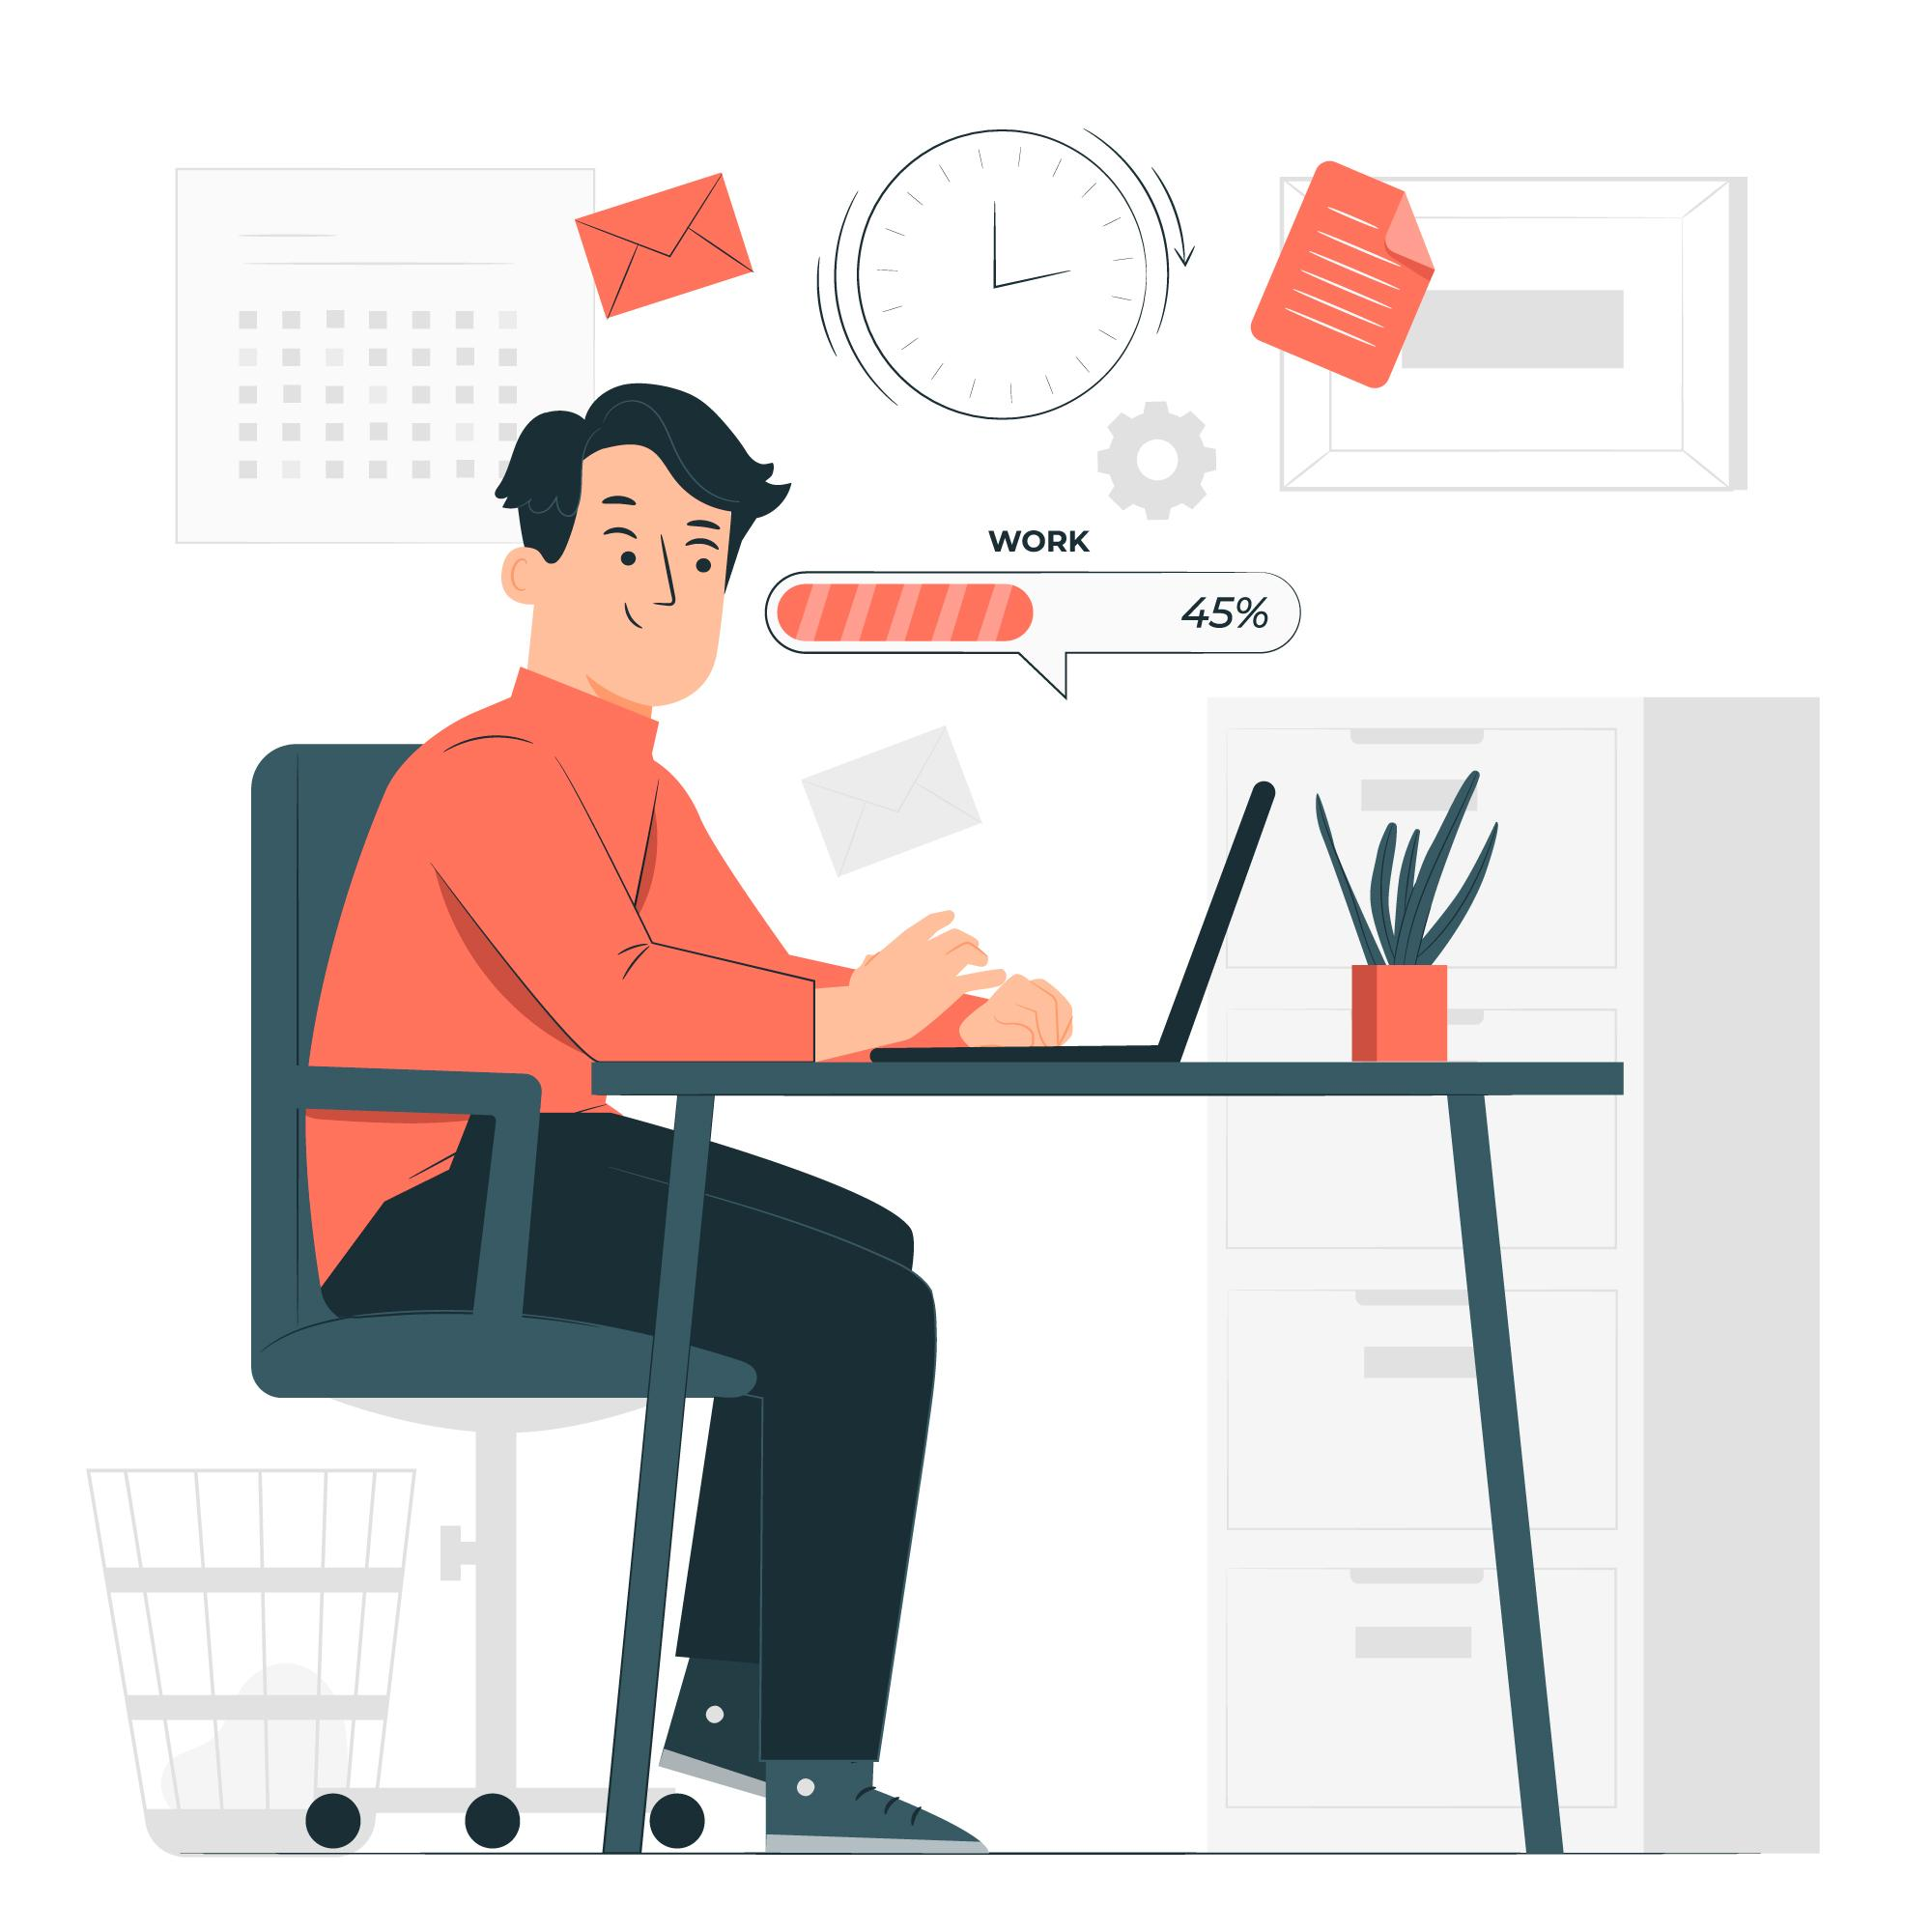
[Image by storyset](https://www.freepik.com/free-vector/work-progress-concept-illustration_12832654.htm#query=work%20in%20progress&position=46&from_view=search) on Freepik